# Summary
## Global Explanations
The most important feature for both classifiers is LSTAT, and it is the main reason for the differences as well. According to the individual SHAP explanations, there is a natural order to the three labels, where LSTAT's increasing influence is highest for each label in a different value range. The relatively low importance of the difference classes $(2,0)$ and $(0,2)$, and the fact that no actual instances are classified like that indicate this as well. I found out, that the difference class $(0,1)$ has its peak between 10.3 and 14.9, $(1,0)$ between 16.3 and 16.8, $(1,2)$ between 3.5 and 11.6 and $(2,1)$ between 6.0 and 7.5.

## Local Explanations
### $(0,1)$
#### First Cluster
Characteristics:
- LSTAT between 11.45 and 20.4:
  - below, both conclude on class 1
  - above, both conclude on class 0
- low ZN (≤12.5): above, both conclude on class 1
- low RM (<6.7)
- high AGE (≥1)

Observed local differences (1/50 predicted $(0,1)$):
- LSTAT between 13.9 and 14.7
  - below, both conclude on class 1
  - above, both conclude on class 0
- CRIM between 3.4 and 4.4
  - below, both conclude on class 1
  - above, both conclude on class 0

#### Second Cluster
Characteristics:
- high LSTAT (>10.3): below, both conclude on class 1
- low ZN (=0): at 2, both conclude on class 1
- low RM (<7.0)

Observed local differences (2/77 predicted $(0,1)$):
- LSTAT up to 14.9: above, both conclude on class 0
- CRIM up to 2.5: above, both conclude on class 0

### $(1,0)$
Characteristics:
- high LSTAT (>10.5): below, both conclude on class 1
- low ZN (≤75)
- RM (<6.9)

Observed local differences (2/115 predicted $(1,0)$):
- LSTAT between 16.3 and 16.8
  - below, both conclude on class 1
  - above, both conclude on class 0
- ZN up to 1: above, both conclude on class 1

### $(1,2)$
Characteristics:
- low LSTAT (≤13): above, both conclude on class 1
- low INDUS (<19.6): above, both conclude on class 1

Observed local differences (5/126 predicted $(1,2)$):
- LSTAT between 3.5 and 11.6
  - below, both conclude on class 2
  - above, both conclude on class 1
- ZN above 16: below, both conclude on class 1

### $(2,1)$
Characteristics:
- low LSTAT (≤9.6): above, both conclude on class 1
- low ZN (=0): at 19, both conclude on class 2
- low INDUS (<19.6): at 19.7, both conclude on class 1 

Observed local differences (2/32 predicted $(2,1)$):
- LSTAT between 6.0 and 7.5
  - below, both conclude on class 2
  - above, both conclude on class 1
- INDUS above 9: below, both conclude on class 2

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
import xgboost
from sklearn.metrics import classification_report
from comparers import ModelComparer
from sklearn.model_selection import StratifiedKFold, train_test_split
from helper_models import LogProbabilityMixin
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from kneed import KneeLocator
import joblib
shap.initjs()
task_name = 't4'

In [2]:
try:
    with open(task_name + '.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    with open(task_name + '.comparer', 'rb') as f:
        comparer = pickle.load(f)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
    global_feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)
except FileNotFoundError:
    pass

# Setup Task

In [3]:
X = pd.read_csv('test_data.csv')
y = X['price']
X = X.drop(columns=['Unnamed: 0', 'price'])
feature_names = X.columns.to_numpy()
class_names = y.unique().astype(str)
X.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,2.720010,12.841063,11.718208,0.572581,6.511388,1.304878,3.501706,9.346908,403.132604,18.125578,11.736981
std,6.388147,25.552540,7.290396,0.125307,0.889747,0.813494,2.007156,8.493772,165.416533,2.524334,7.372550
min,0.009060,0.000000,1.210000,0.389000,3.561000,0.000000,1.137912,1.000000,188.000000,13.000000,1.763949
25%,0.099321,0.000000,4.243588,0.462112,5.882000,1.000000,1.967365,4.000000,273.000000,15.707491,5.008267
50%,0.540032,0.000000,9.900000,0.544000,6.315500,2.000000,2.866600,5.000000,362.186013,18.571912,9.950000
75%,3.181873,20.000000,18.100000,0.638740,7.134552,2.000000,4.621654,8.000000,461.000000,20.200000,17.091674
max,73.534100,100.000000,25.650000,0.871000,8.638029,2.000000,10.710300,24.000000,679.526743,22.000000,36.980000


In [4]:
X['AGE'].value_counts()

2.0    130
1.0     61
0.0     55
Name: AGE, dtype: int64

In [5]:
clf_a = joblib.load('model_A.joblib')
clf_b = joblib.load('model_C.joblib')
comparer = ModelComparer(clf_a, clf_b, feature_names)
with open(task_name + '.comparer', 'wb') as f:
    pickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


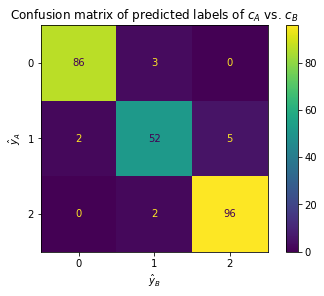

In [6]:
comparer.plot_confusion_matrix(X)

In [8]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite),
                f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 247it [00:28,  6.70it/s]                         
Permutation explainer: 247it [00:17,  5.94it/s]                         
Permutation explainer: 247it [00:46,  4.02it/s]                         

CPU times: user 2min 12s, sys: 13 s, total: 2min 25s
Wall time: 1min 32s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [9]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

In [10]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

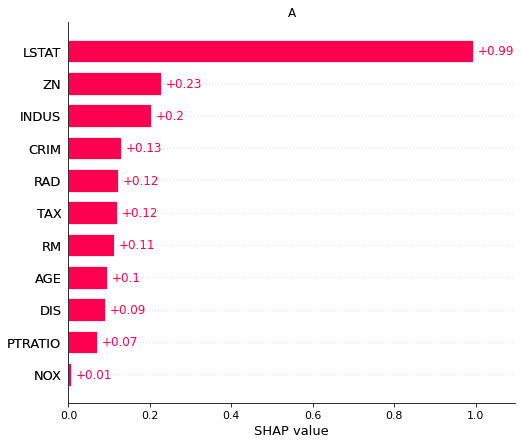

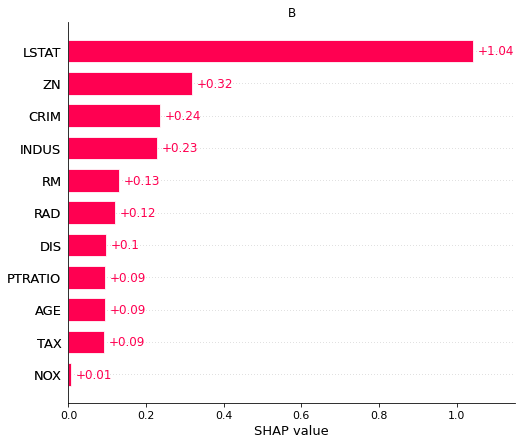

In [11]:
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.A)
plot_feature_importance_bar(feature_importances, 'A')
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.B)
plot_feature_importance_bar(feature_importances, 'B')

In [12]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)

In [13]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects_comparison(color=is_pred_diff,
                                    **{'A': explanations.indiv.log_odds.A[:, [feature_idx]],
                                       'B': explanations.indiv.log_odds.B[:, [feature_idx]]})
it = iter(feature_order)

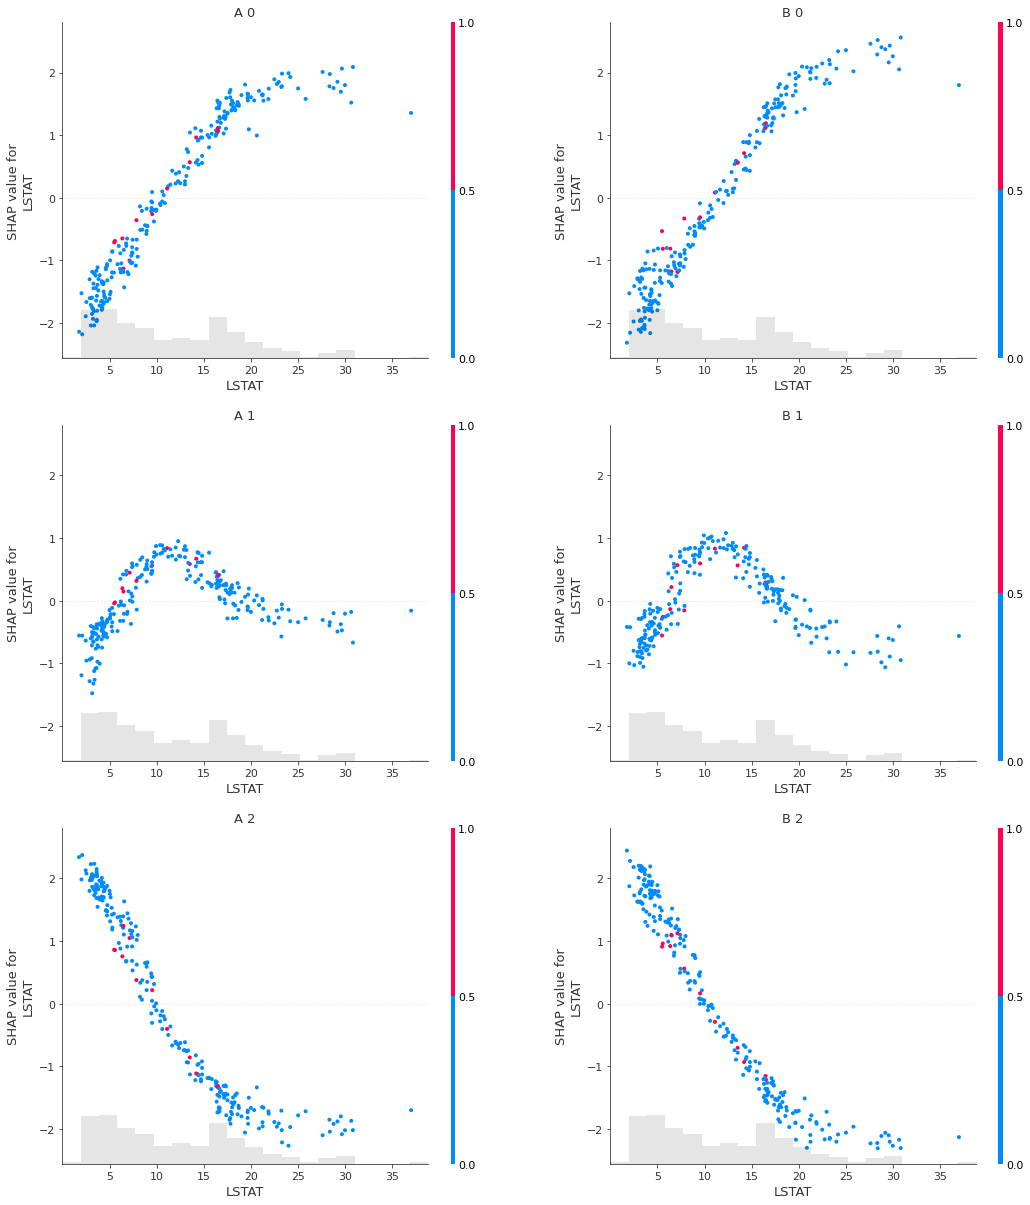

In [14]:
plot_next_feature()

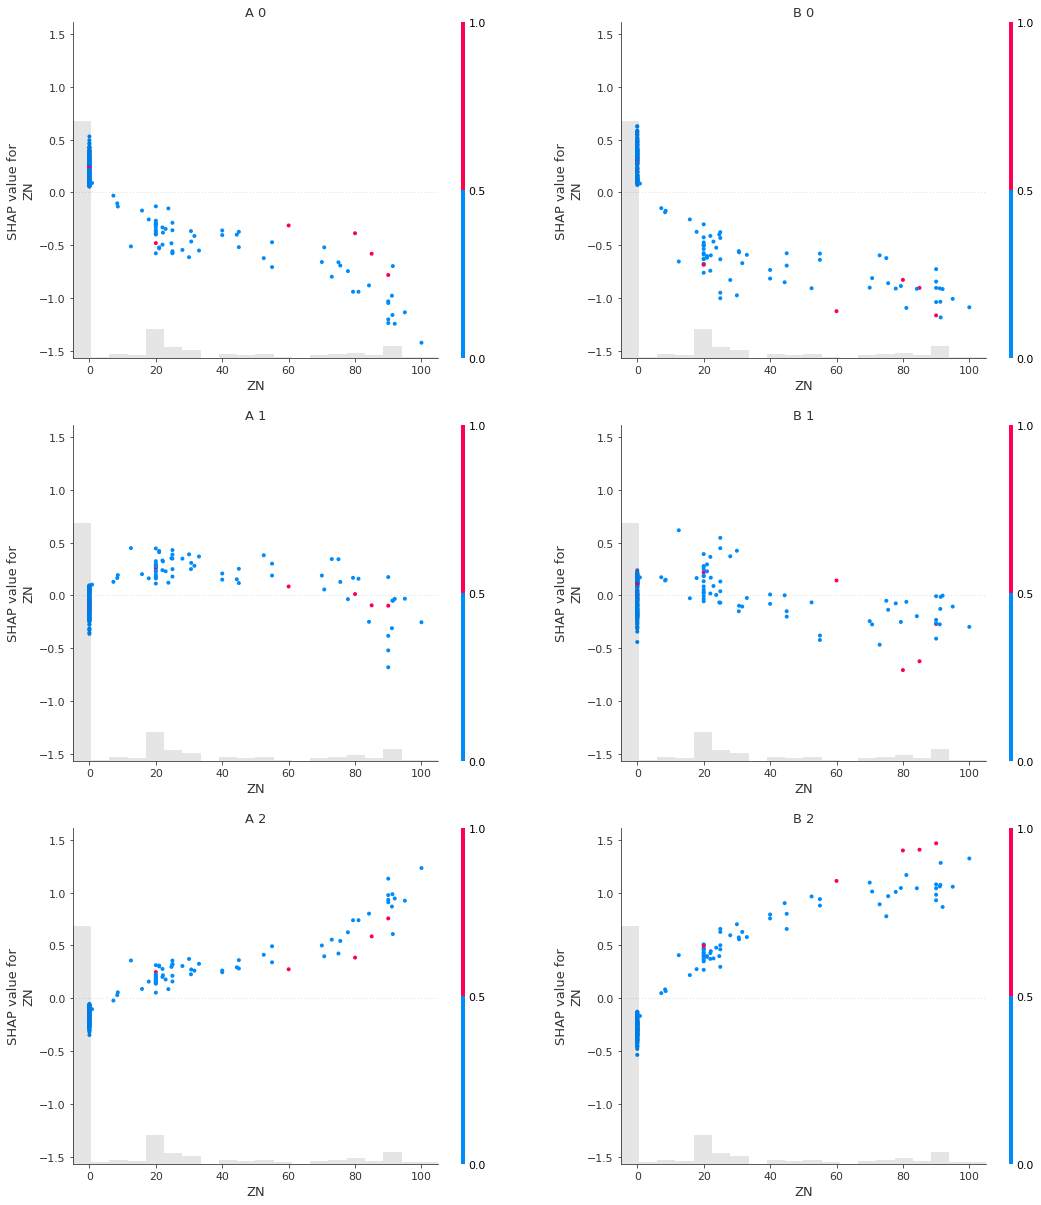

In [15]:
plot_next_feature()

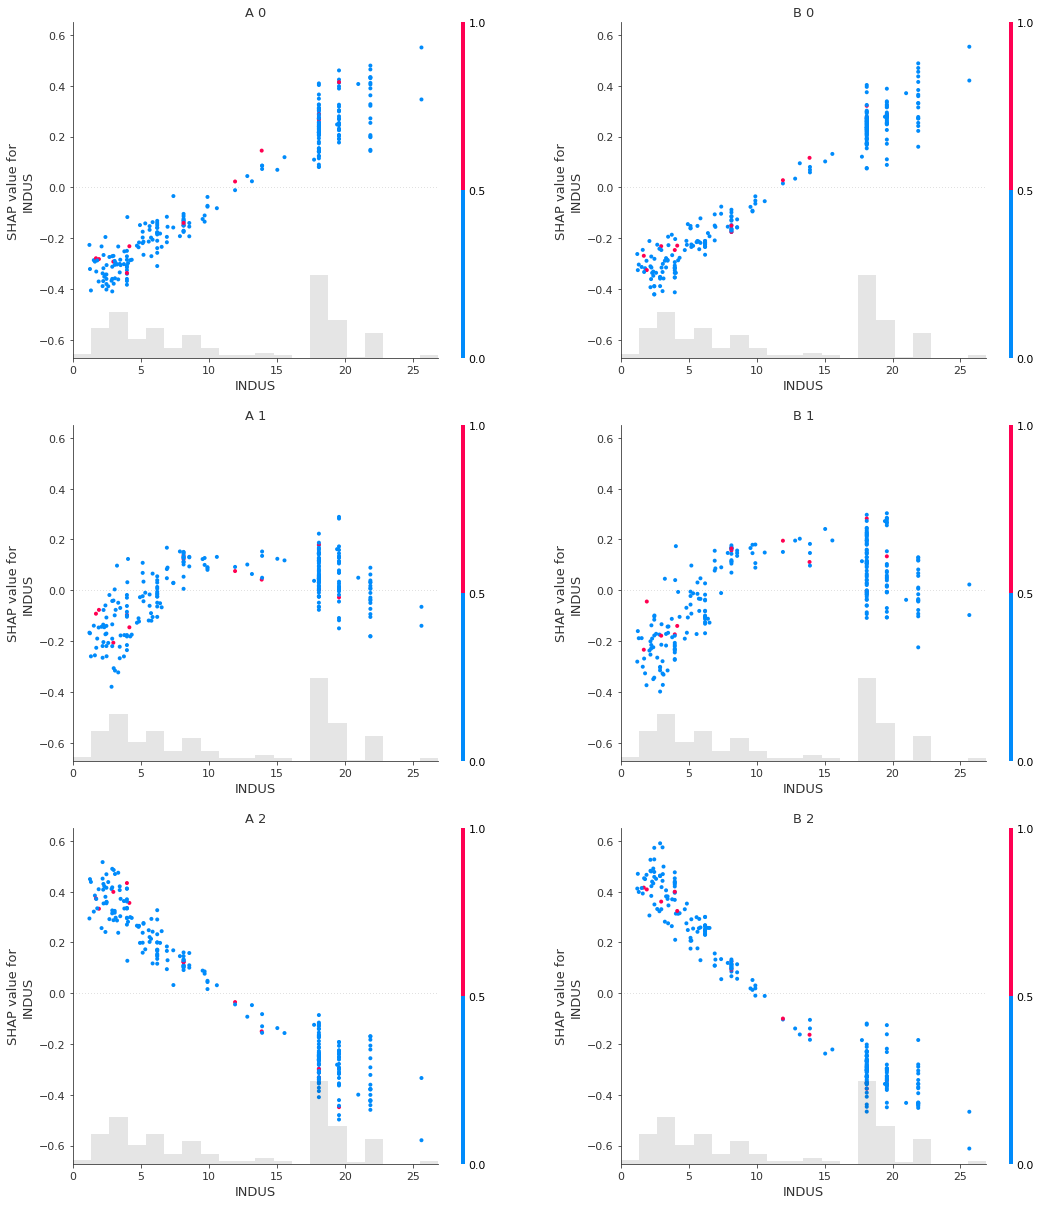

In [16]:
plot_next_feature()

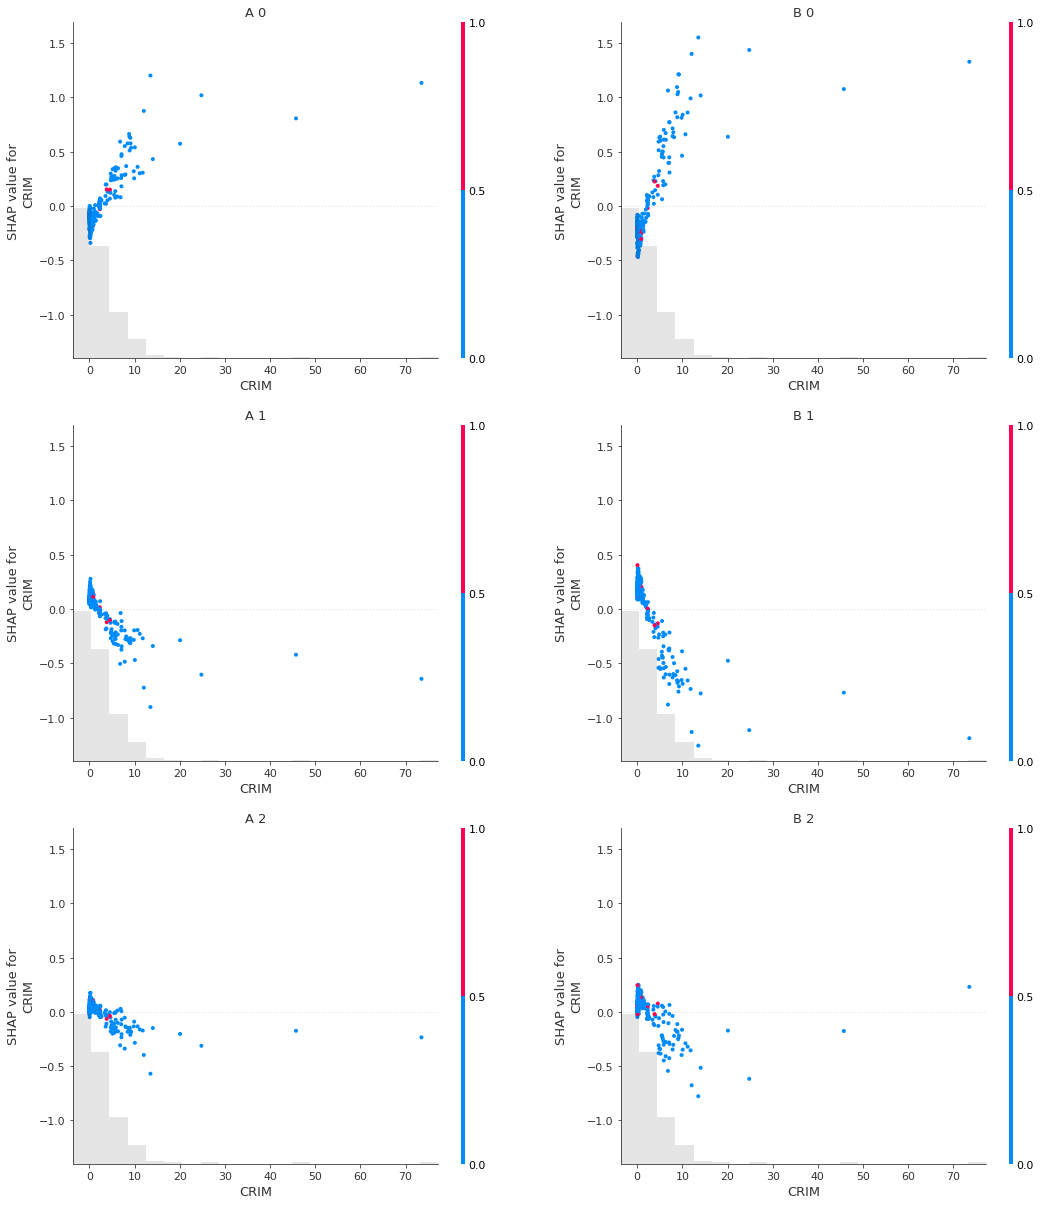

In [17]:
plot_next_feature()

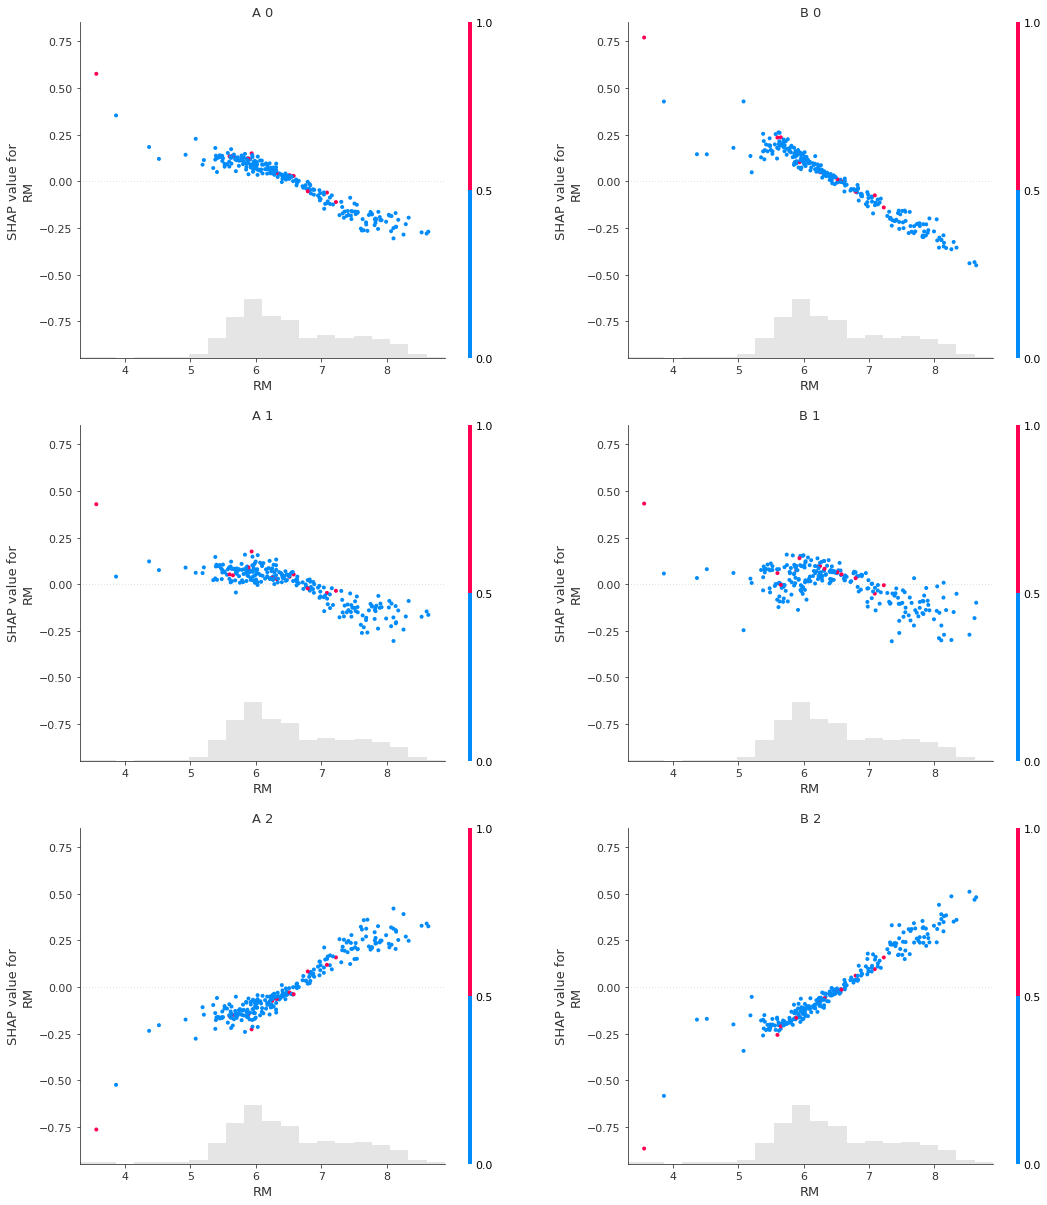

In [18]:
plot_next_feature()

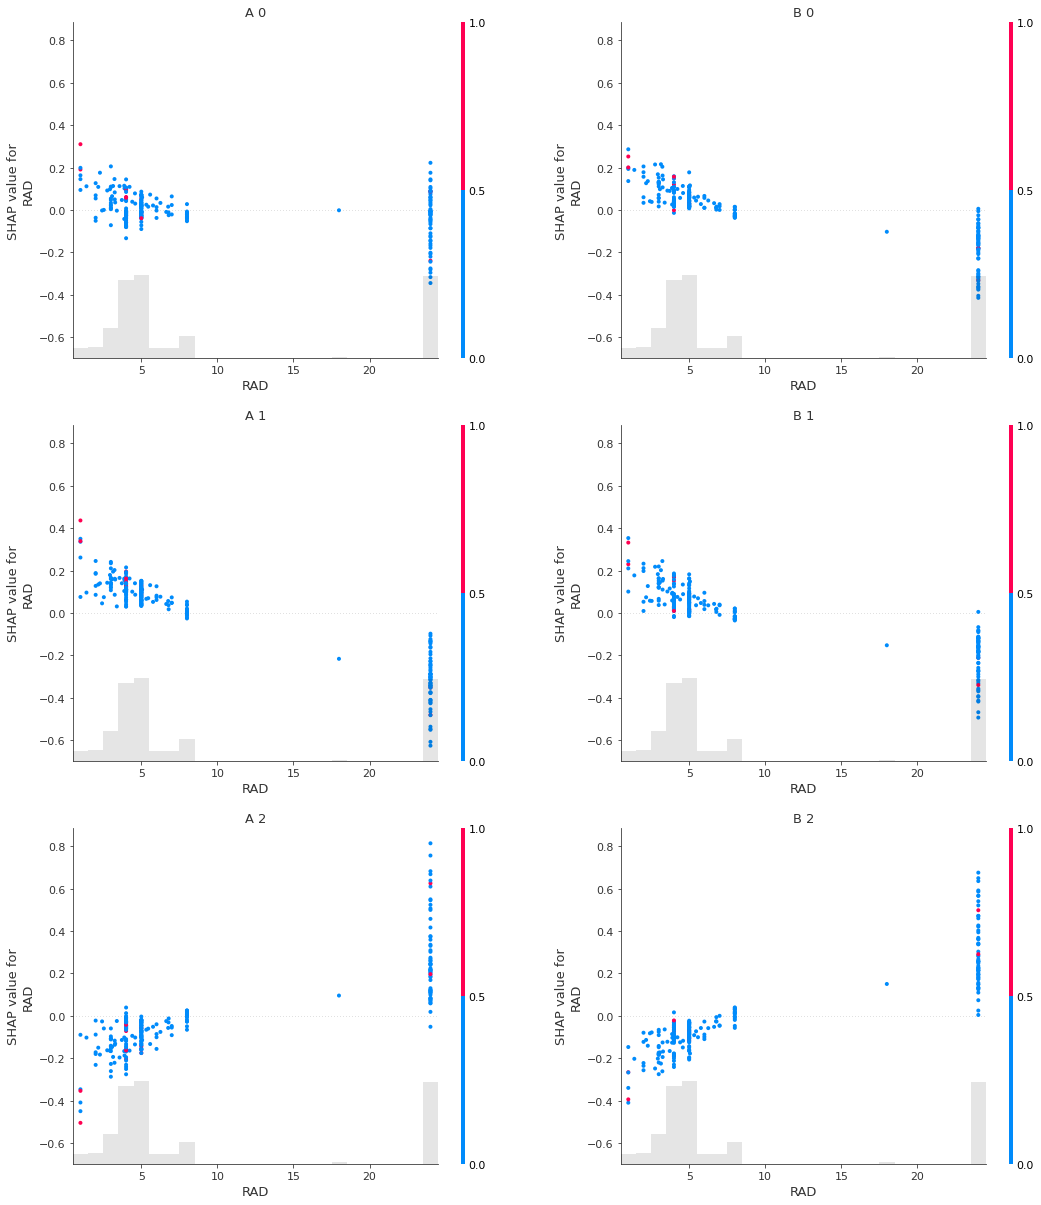

In [19]:
plot_next_feature()

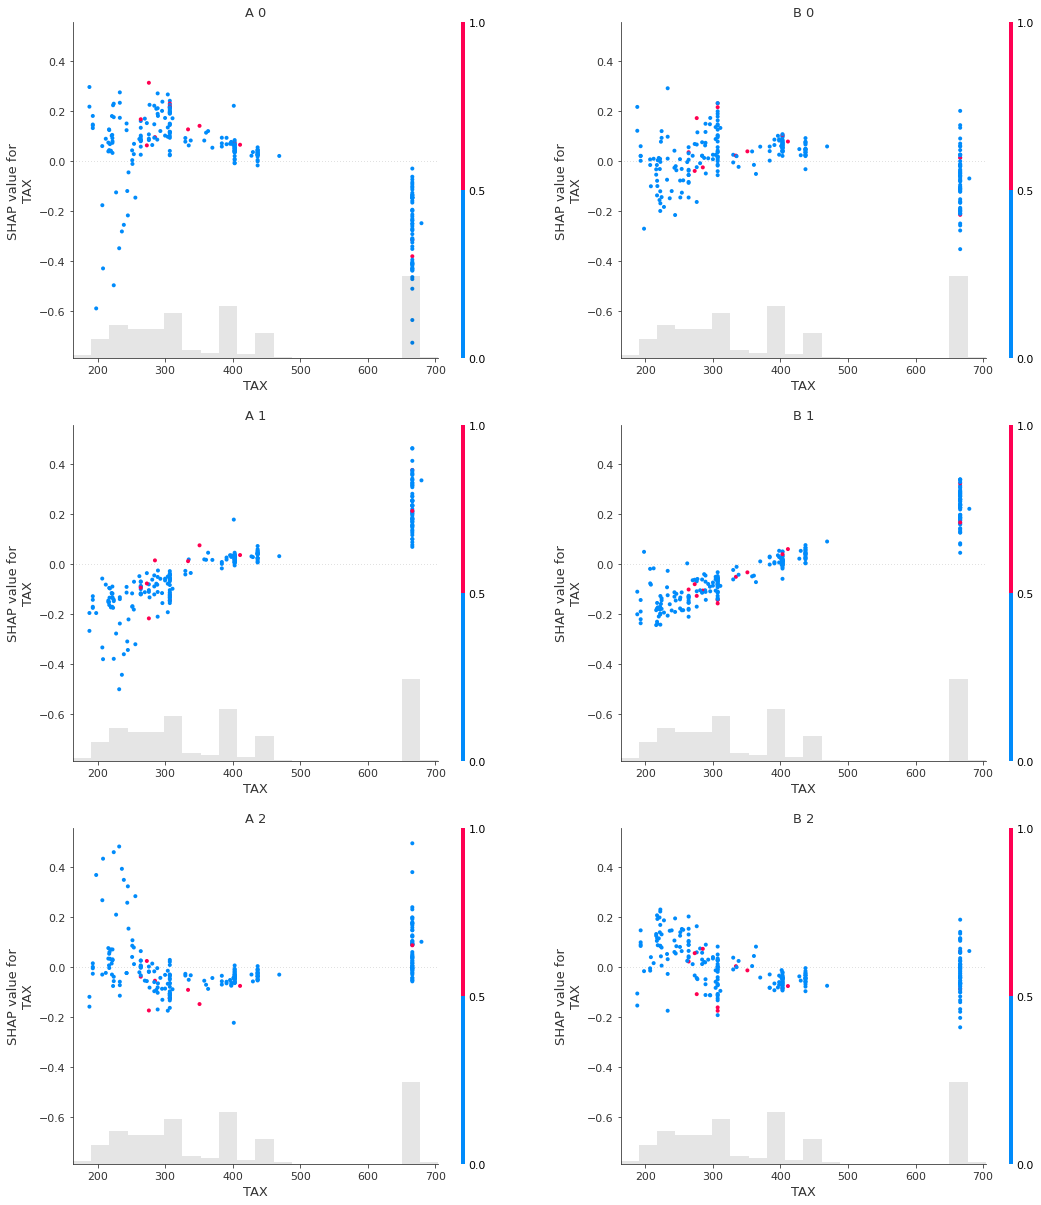

In [20]:
plot_next_feature()

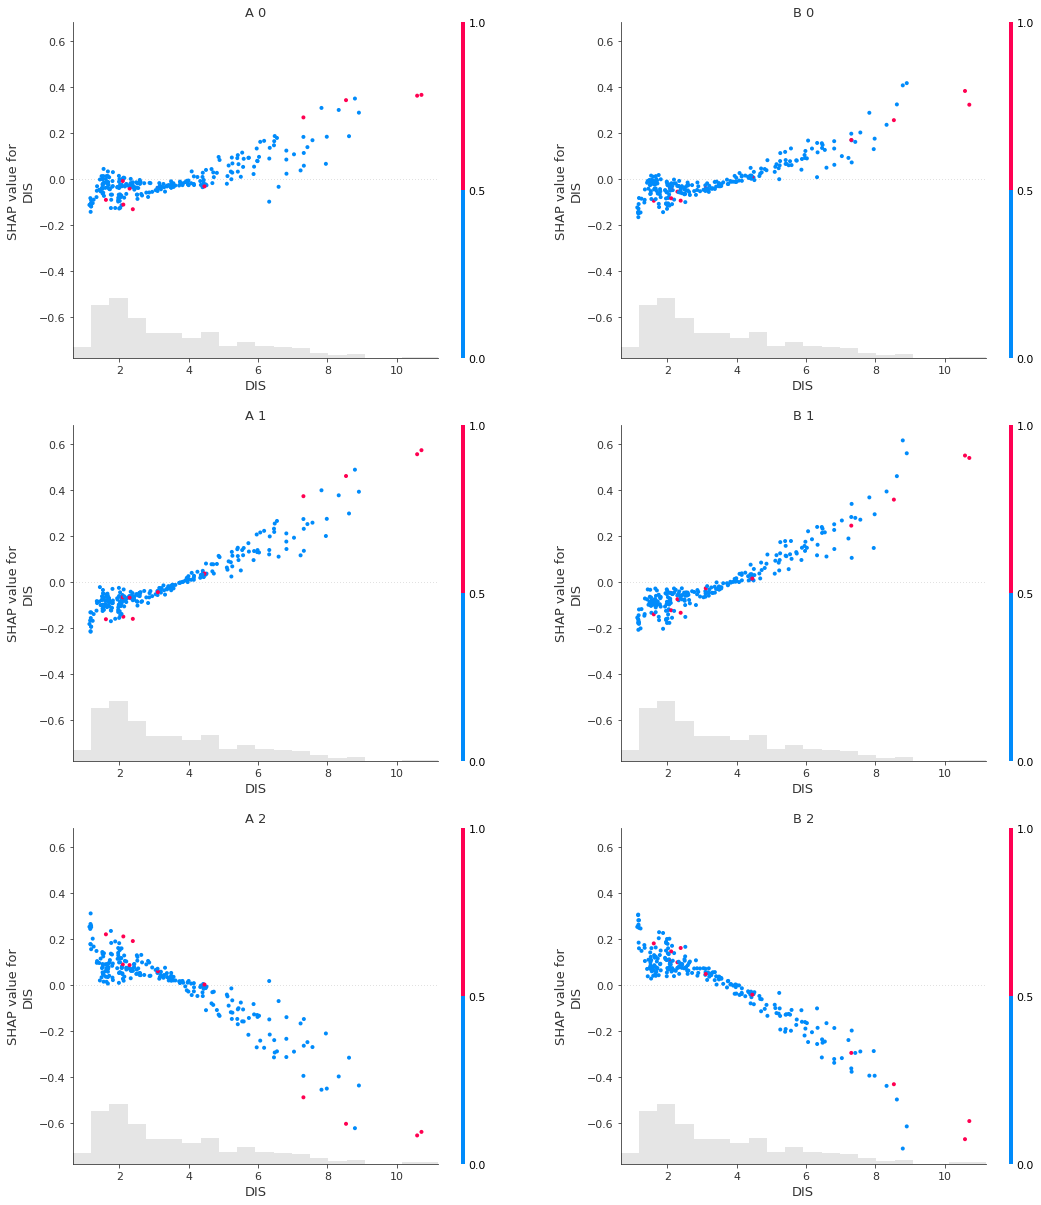

In [21]:
plot_next_feature()

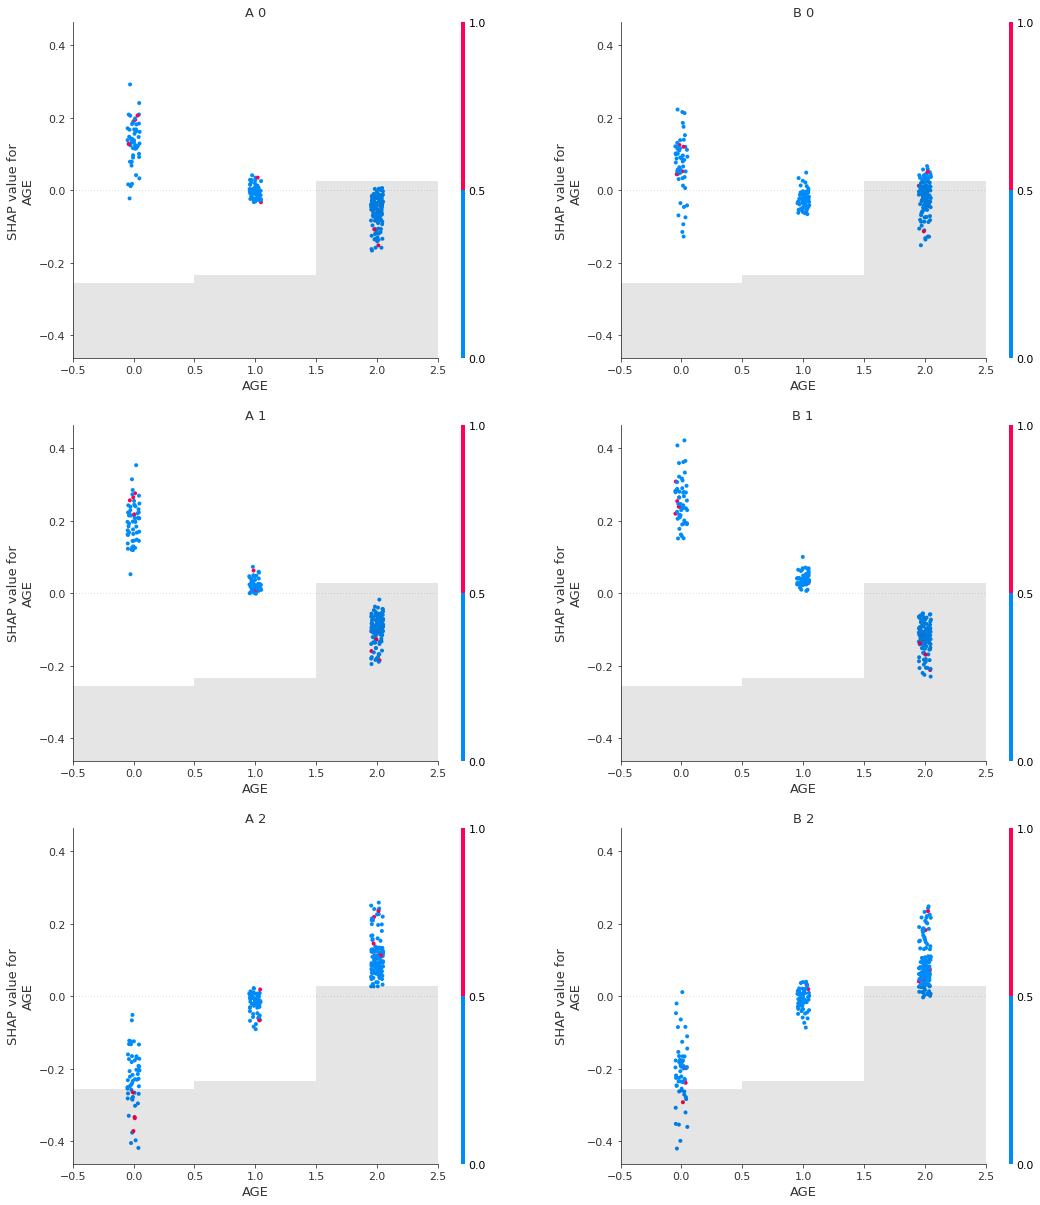

In [22]:
plot_next_feature()

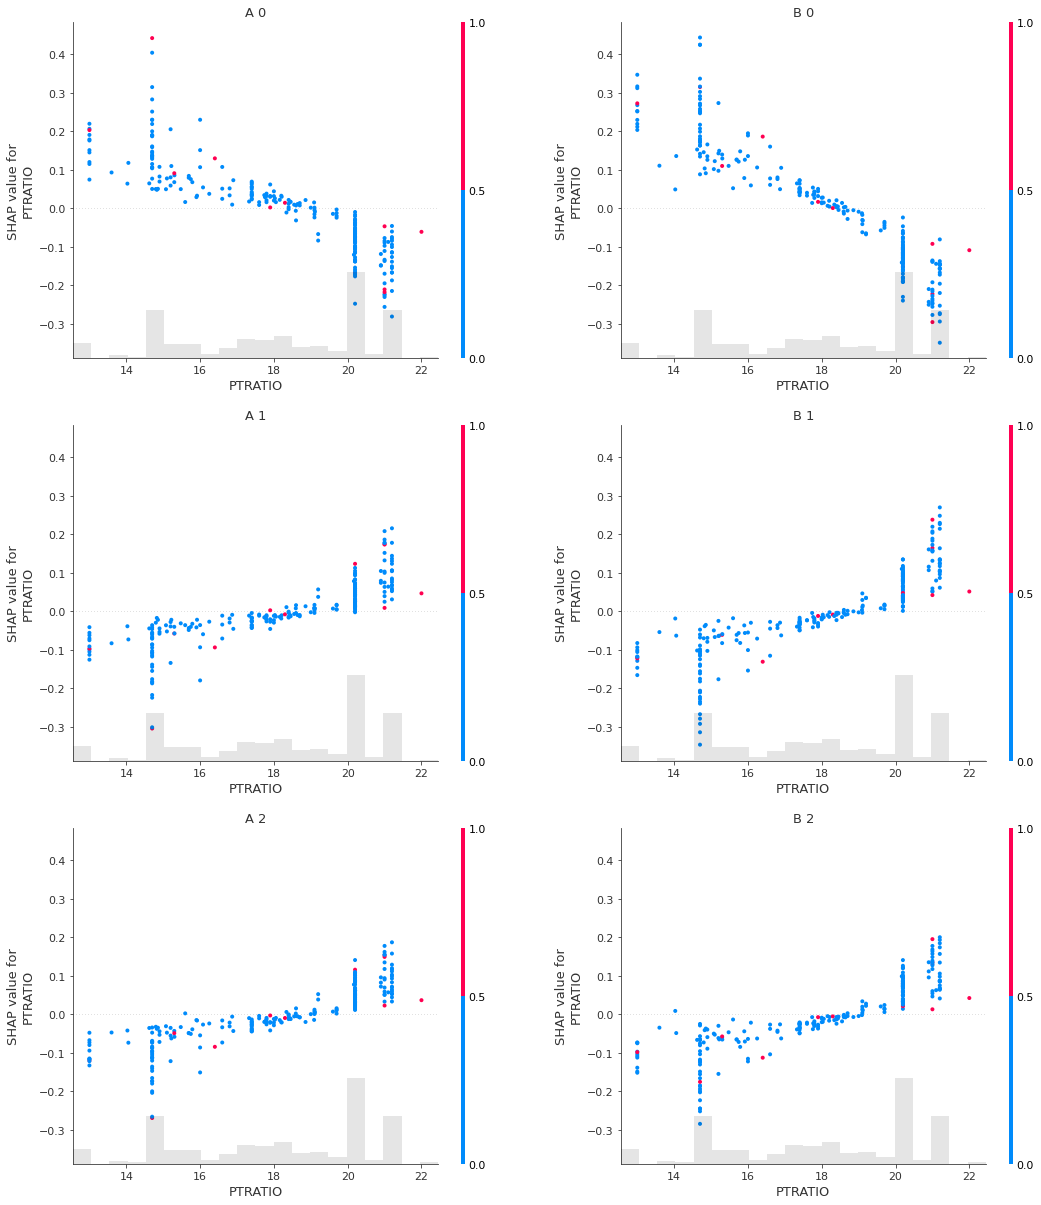

In [23]:
plot_next_feature()

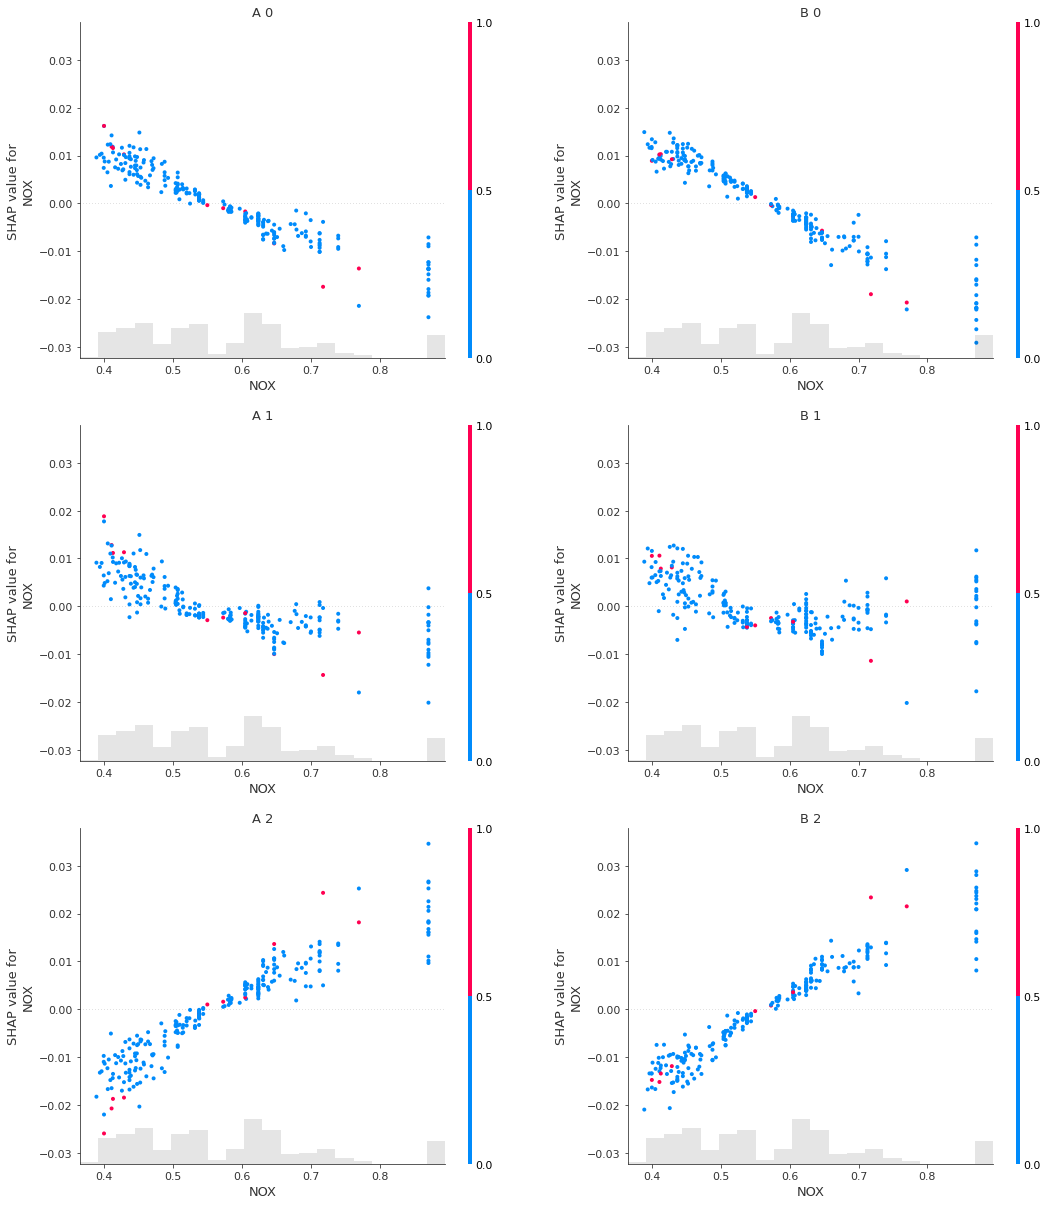

In [24]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

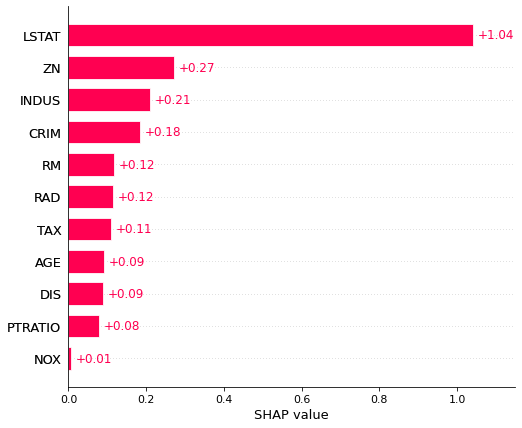

In [26]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
global_feature_order = feature_order
plot_feature_importance_bar(feature_importances)

In [27]:
X.iloc[:, feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,11.736981,12.841063,11.718208,2.720010,6.511388,9.346908,403.132604,1.304878,3.501706,18.125578,0.572581
std,7.372550,25.552540,7.290396,6.388147,0.889747,8.493772,165.416533,0.813494,2.007156,2.524334,0.125307
min,1.763949,0.000000,1.210000,0.009060,3.561000,1.000000,188.000000,0.000000,1.137912,13.000000,0.389000
25%,5.008267,0.000000,4.243588,0.099321,5.882000,4.000000,273.000000,1.000000,1.967365,15.707491,0.462112
50%,9.950000,0.000000,9.900000,0.540032,6.315500,5.000000,362.186013,2.000000,2.866600,18.571912,0.544000
75%,17.091674,20.000000,18.100000,3.181873,7.134552,8.000000,461.000000,2.000000,4.621654,20.200000,0.638740
max,36.980000,100.000000,25.650000,73.534100,8.638029,24.000000,679.526743,2.000000,10.710300,22.000000,0.871000


In [28]:
X['AGE'].value_counts()

2.0    130
1.0     61
0.0     55
Name: AGE, dtype: int64

The equality classes $(0,0)$ and $(2,2)$ have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

$(0,2)$ and $(2,0)$ have the least importances.

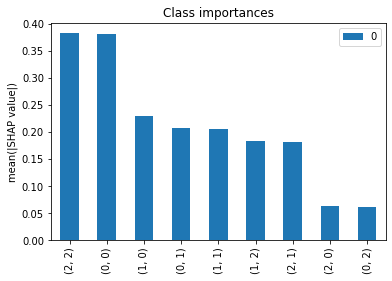

In [29]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [30]:
class_order = np.sort(class_order[:-2])

In [31]:
def plot_next_feature():
    feature_idx = next(it)
    # plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [feature_idx]], class_order=class_order)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[:4]], color=is_pred_diff)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[3:]], color=is_pred_diff)
it = iter(feature_order)

Difference classes $(0,1)$ and $(1,0)$ are at their peak between approx. 11 and 20, $(1,2)$ and $(2,1)$ in the range between approx. 5 and 10.

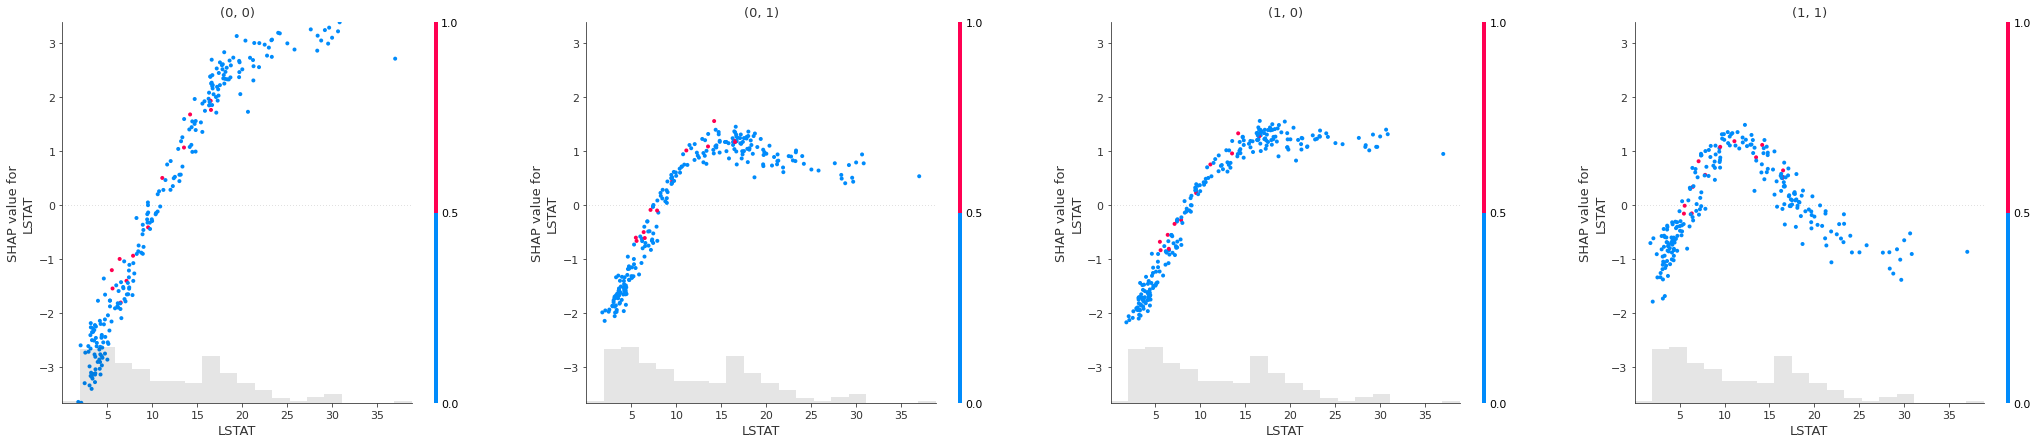

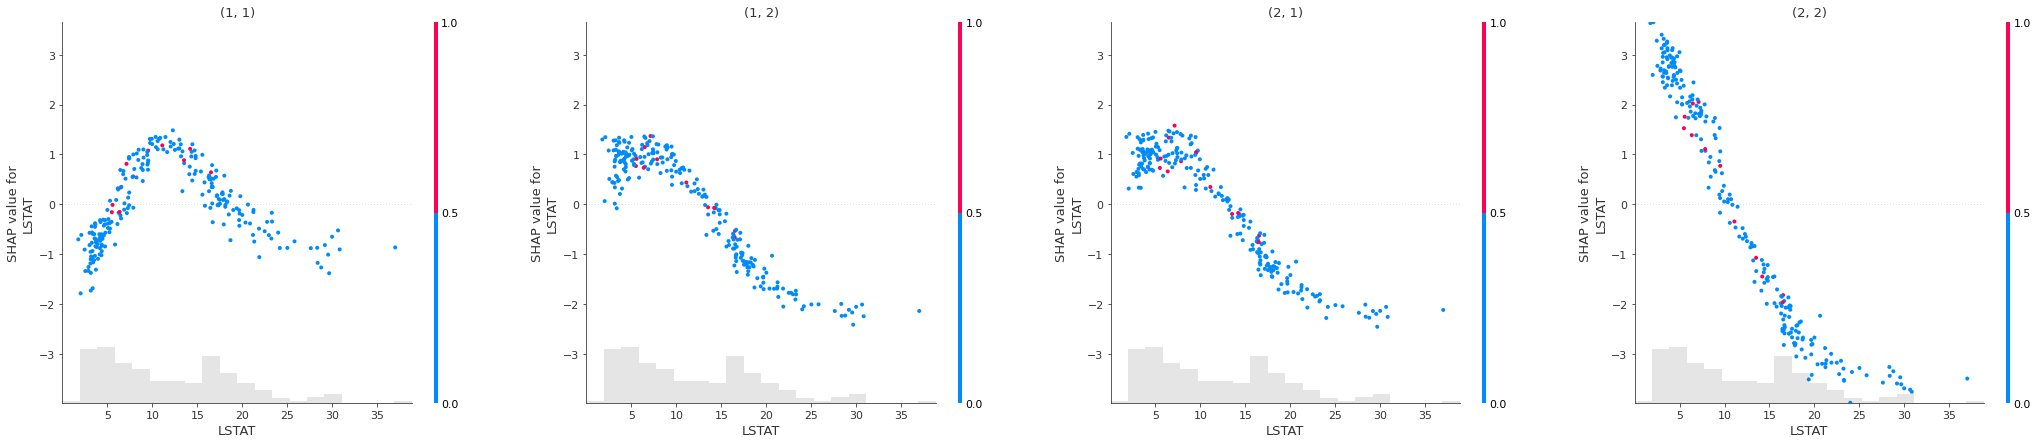

In [32]:
plot_next_feature()

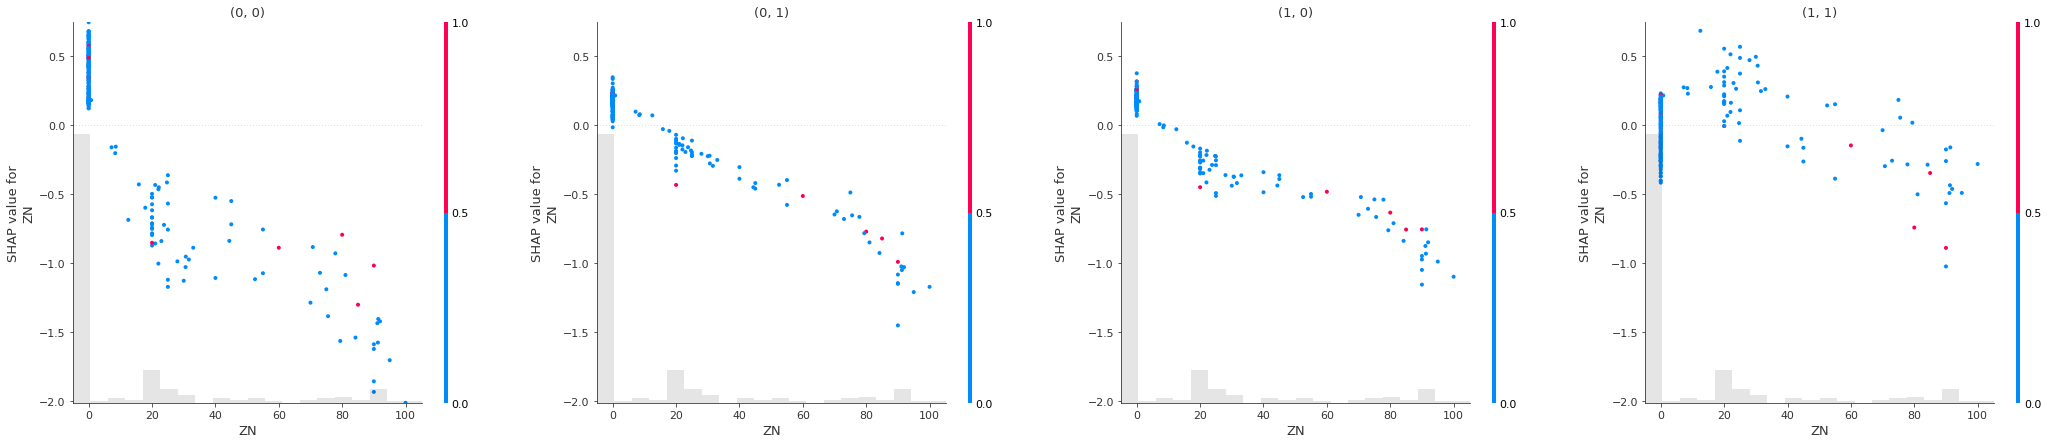

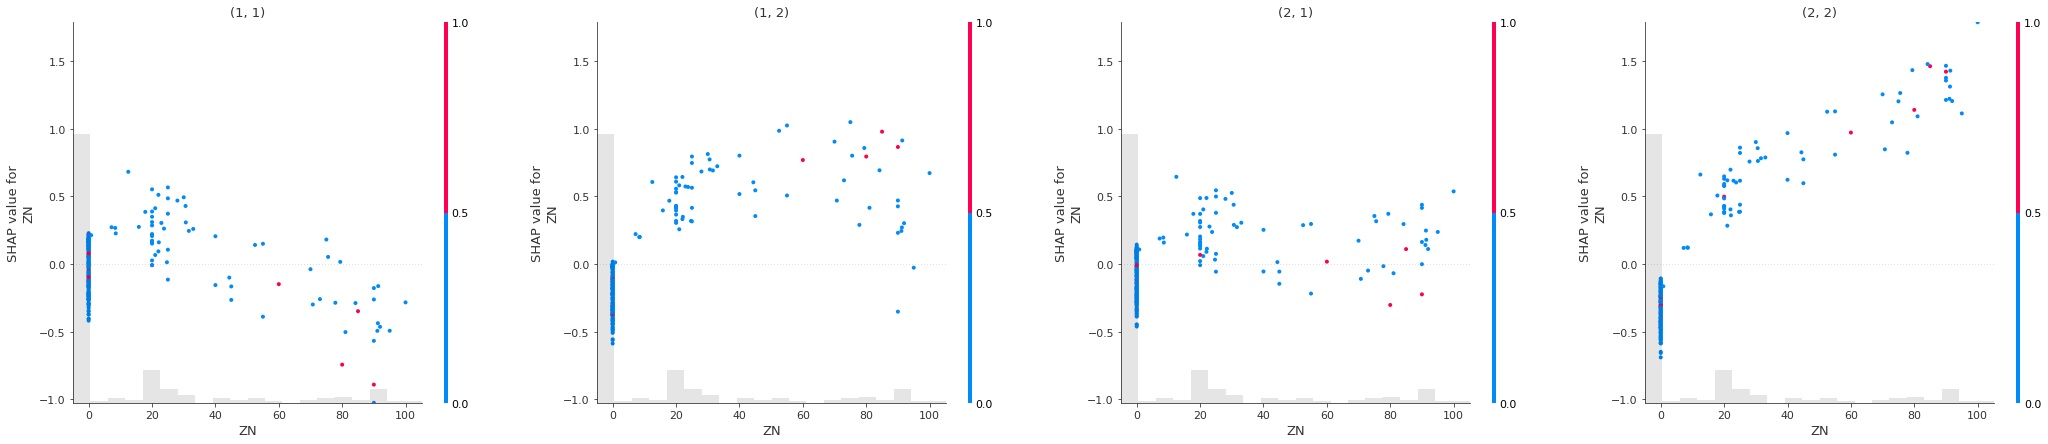

In [33]:
plot_next_feature()

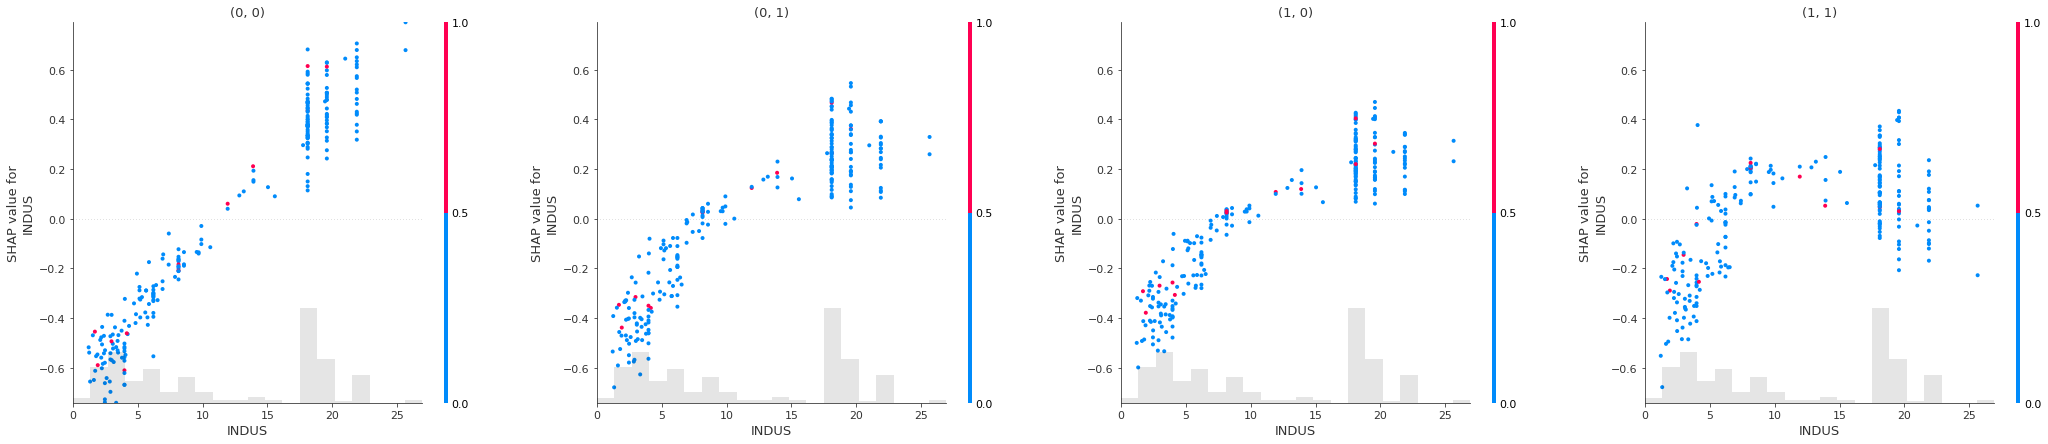

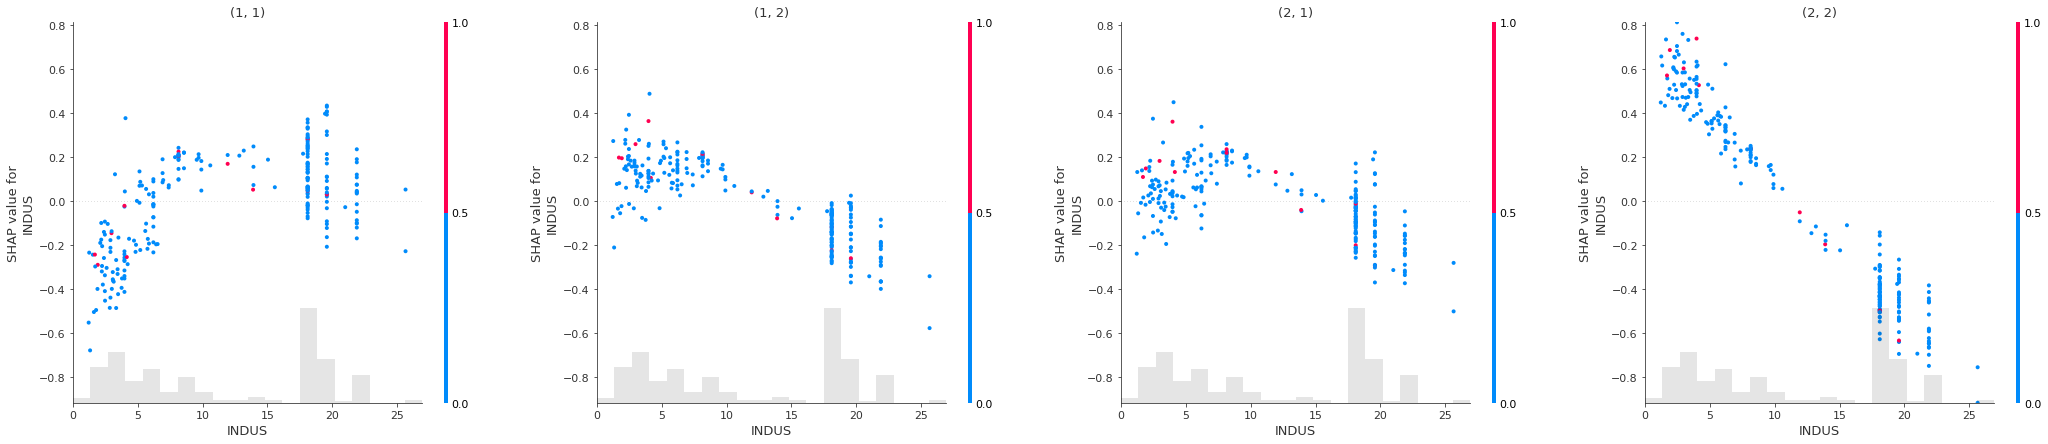

In [34]:
plot_next_feature()

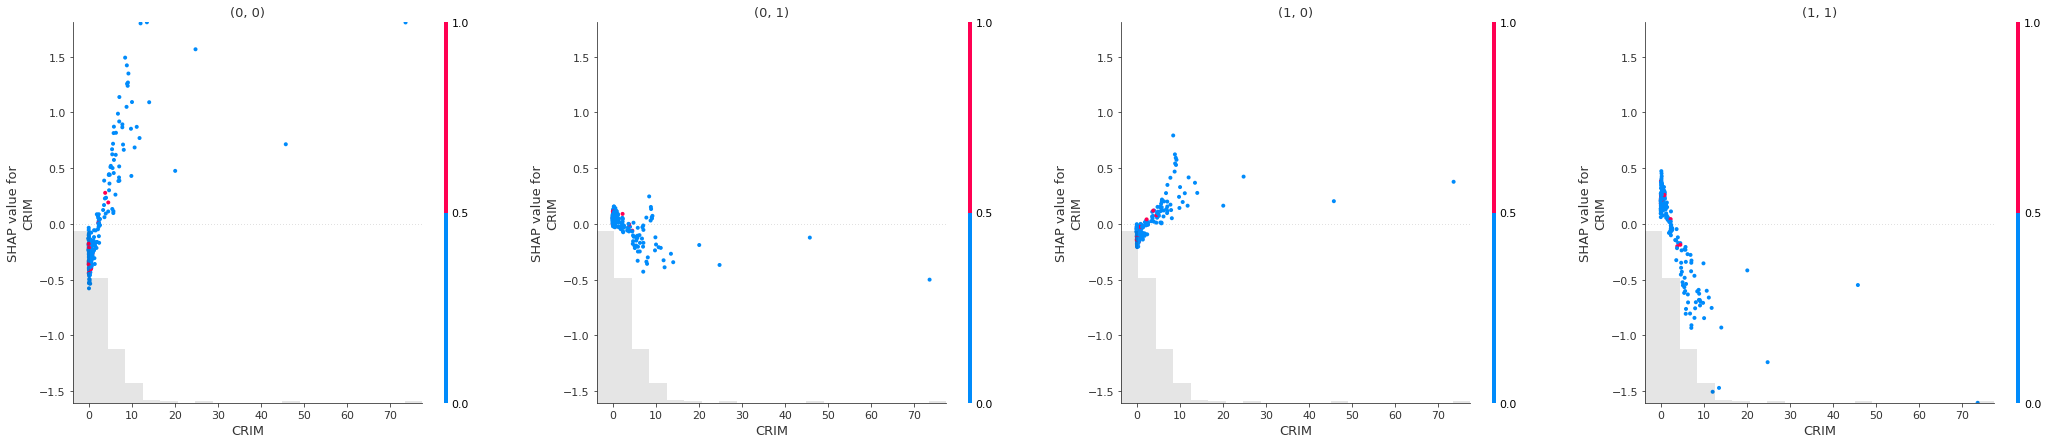

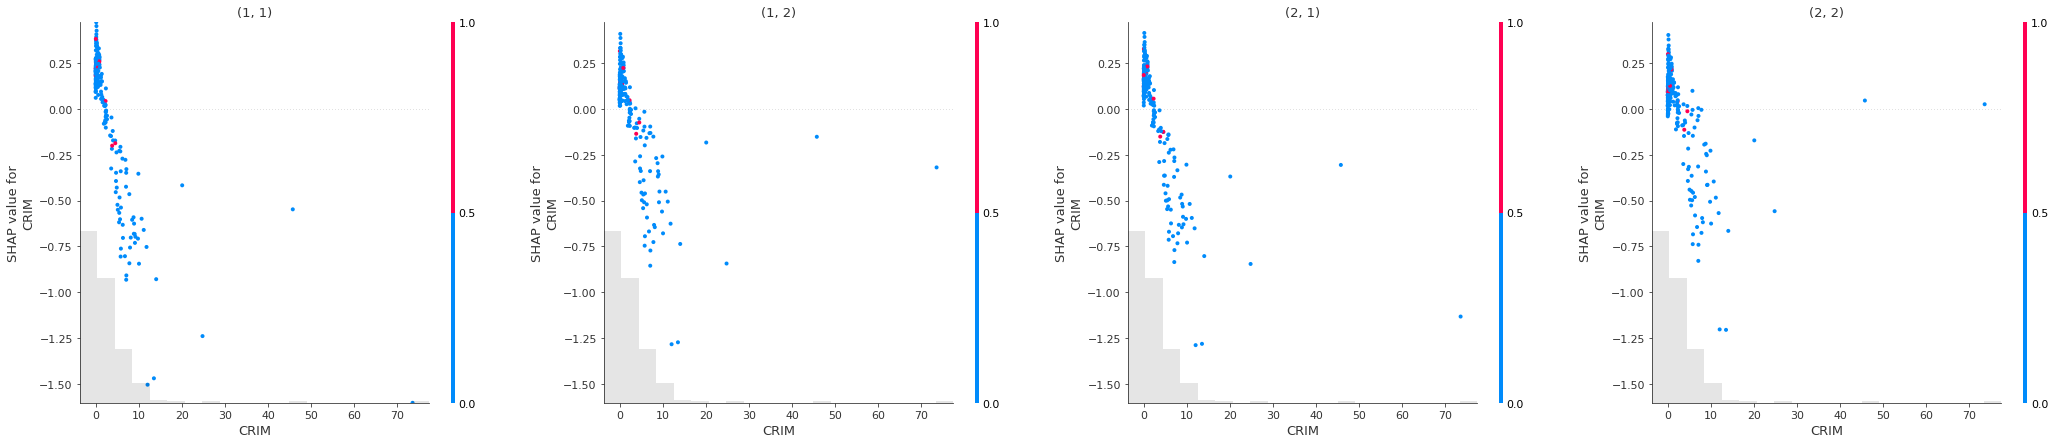

In [35]:
plot_next_feature()

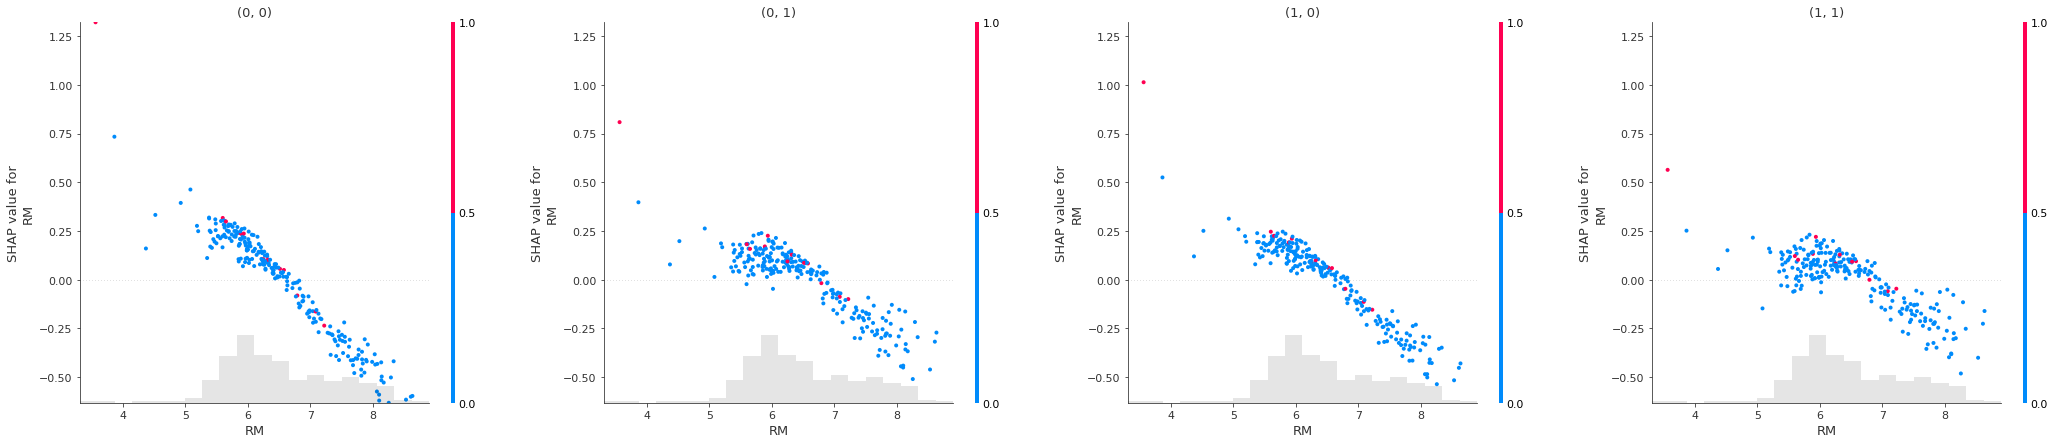

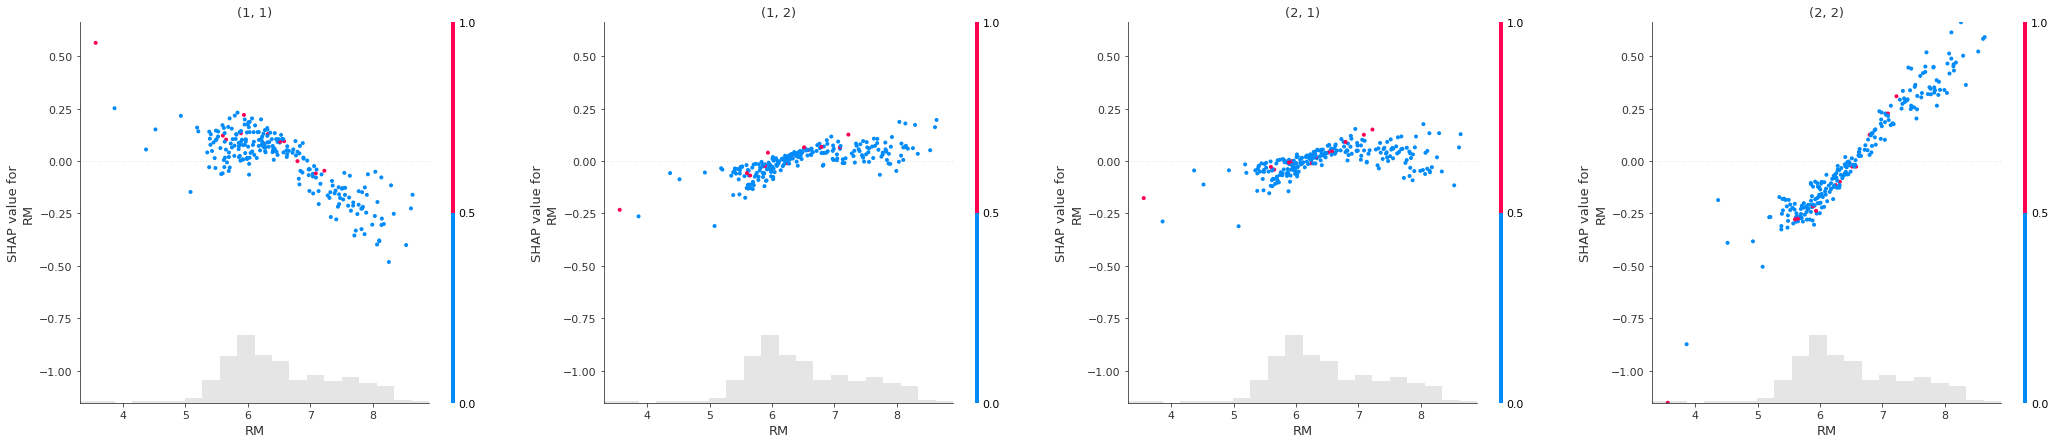

In [36]:
plot_next_feature()

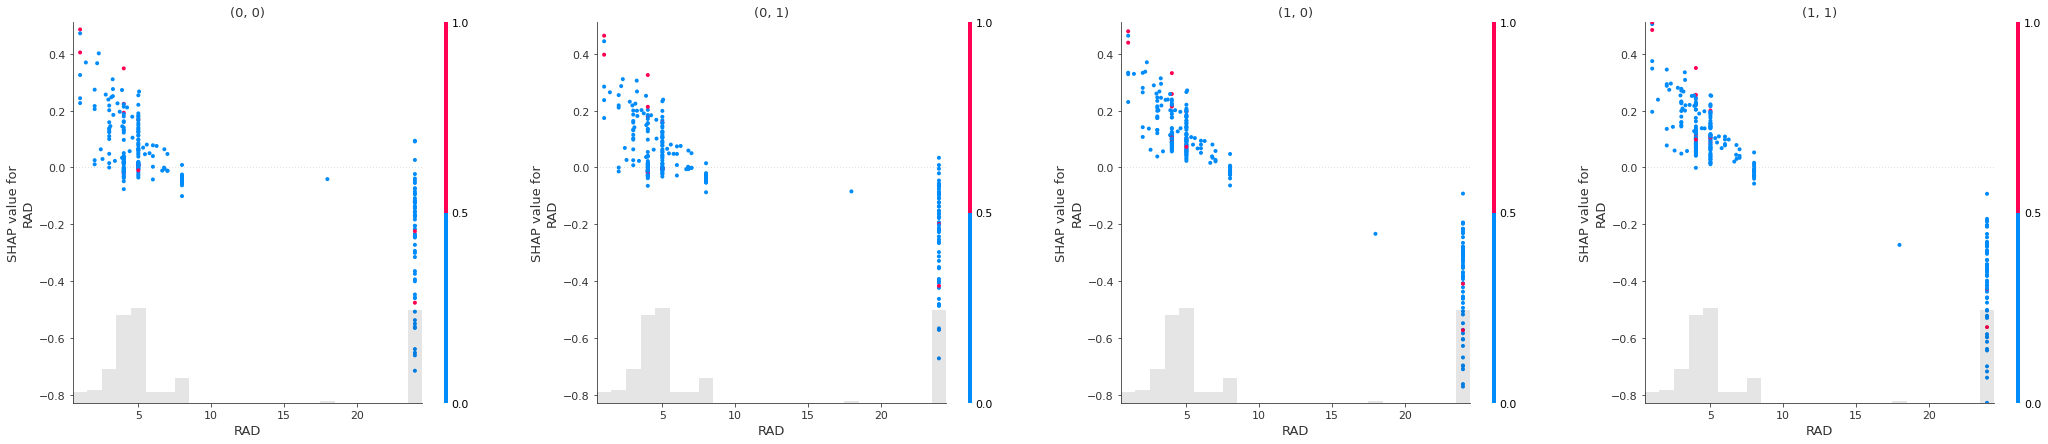

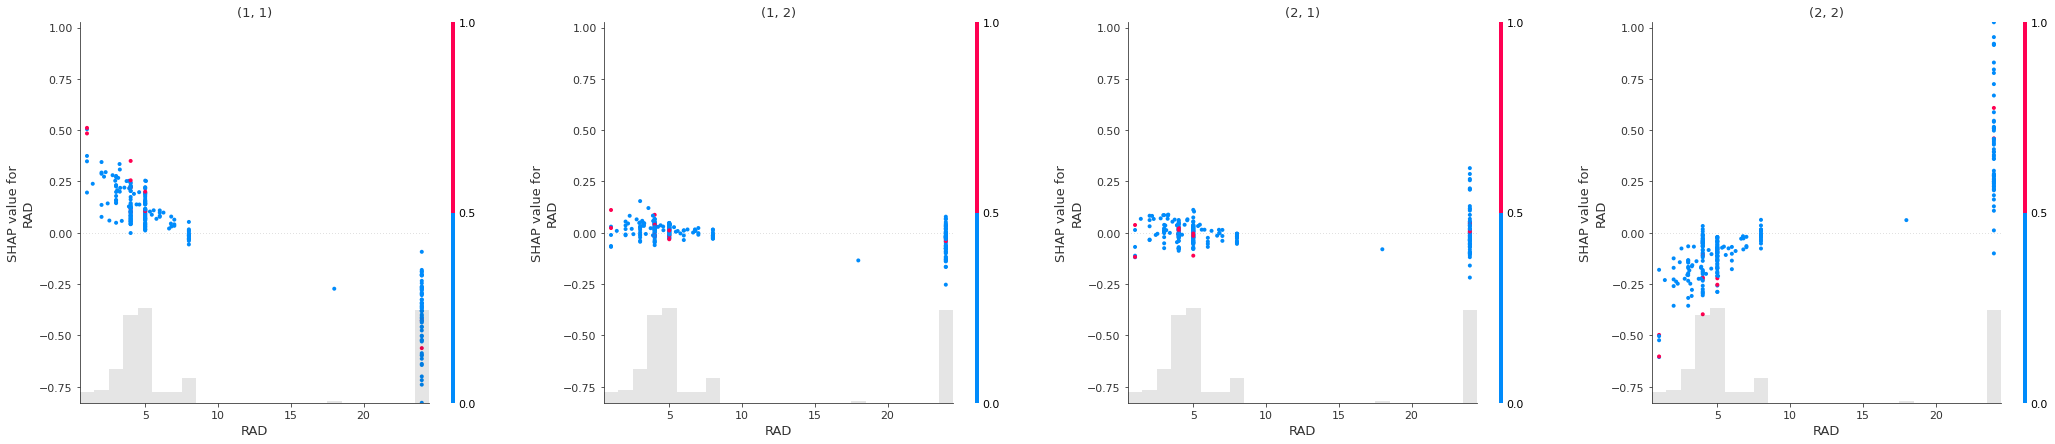

In [37]:
plot_next_feature()

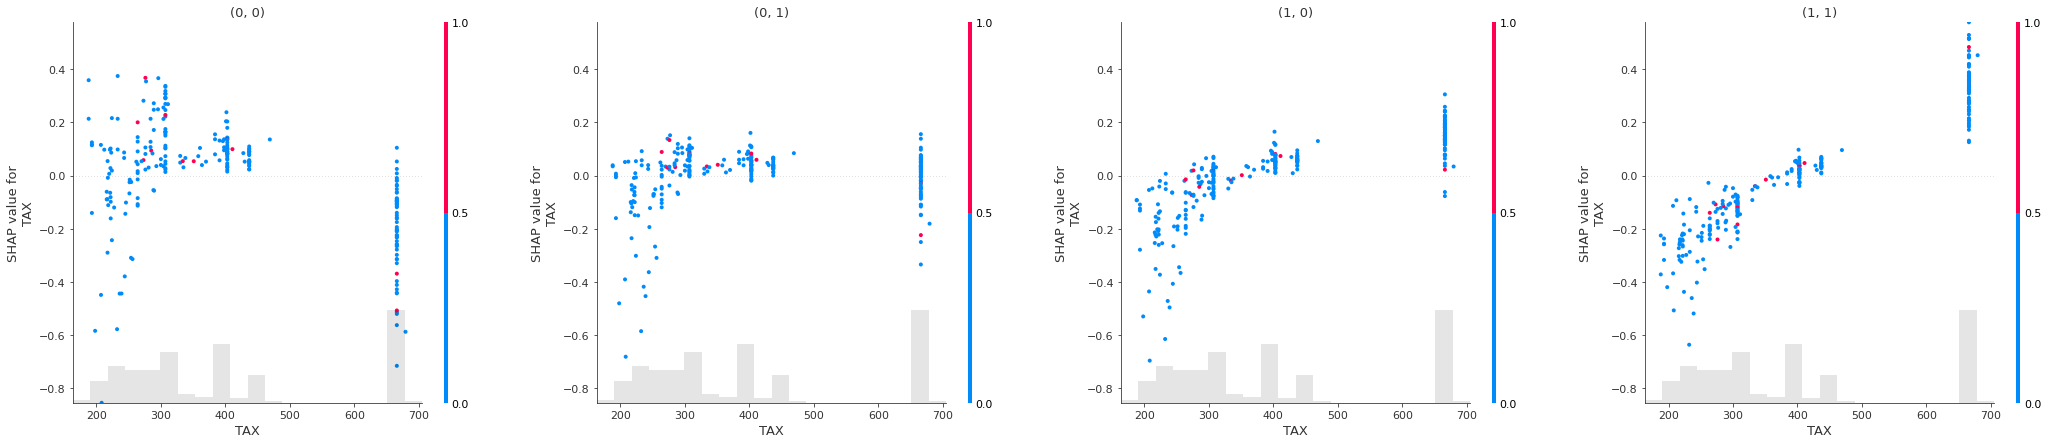

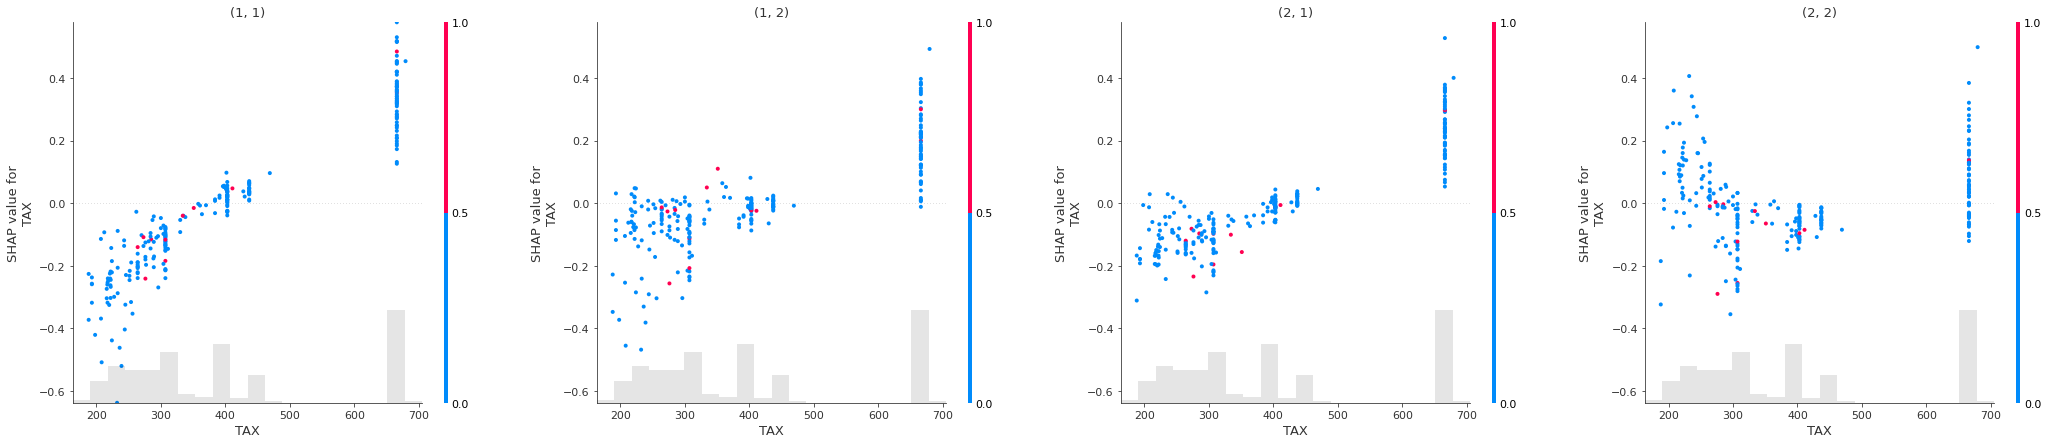

In [38]:
plot_next_feature()

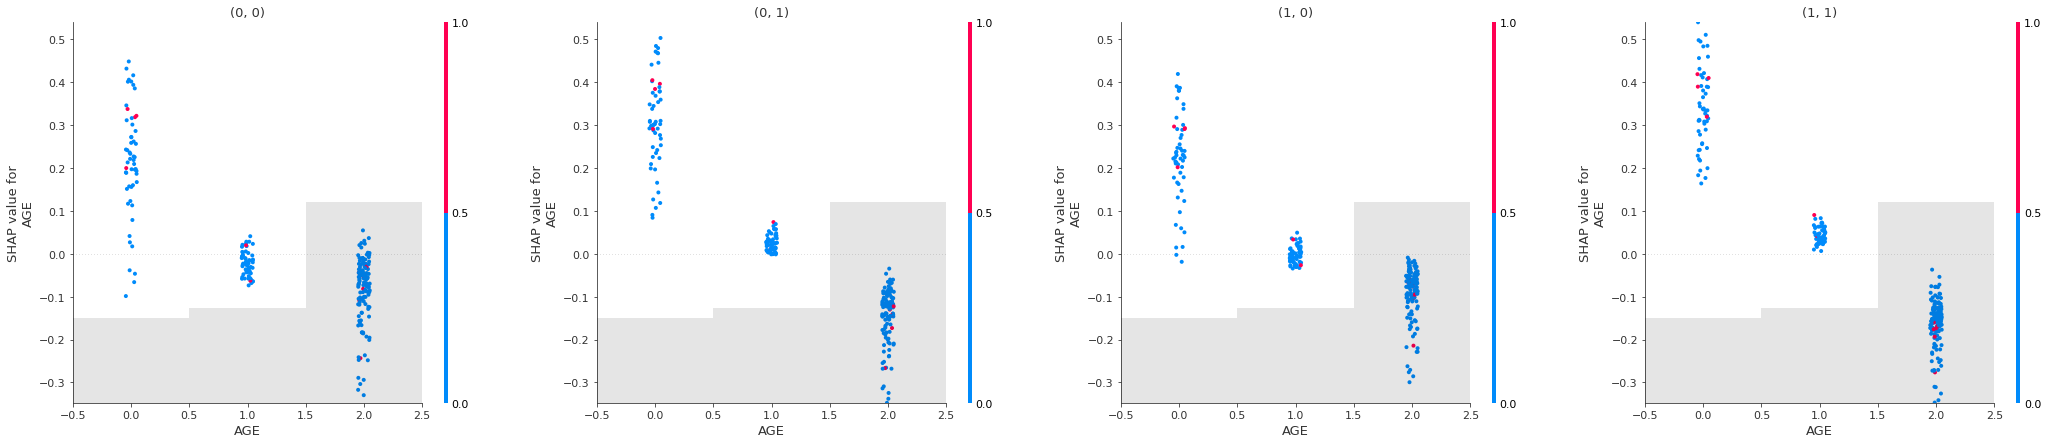

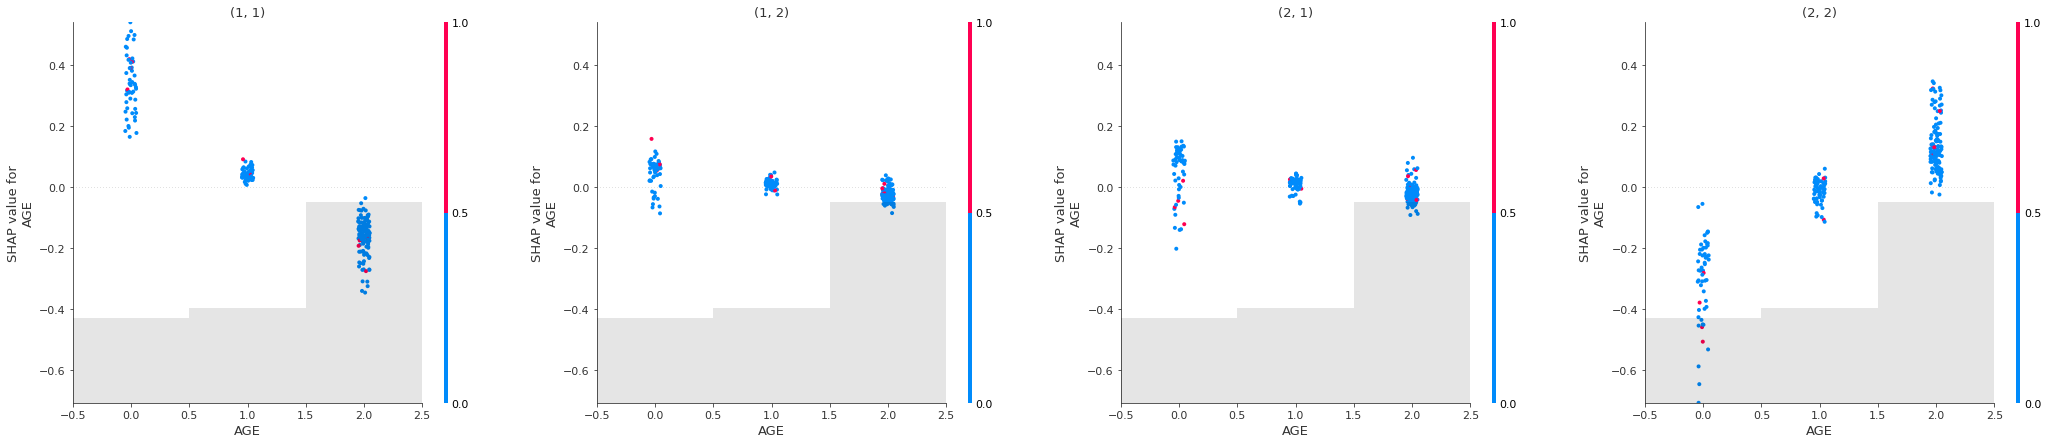

In [39]:
plot_next_feature()

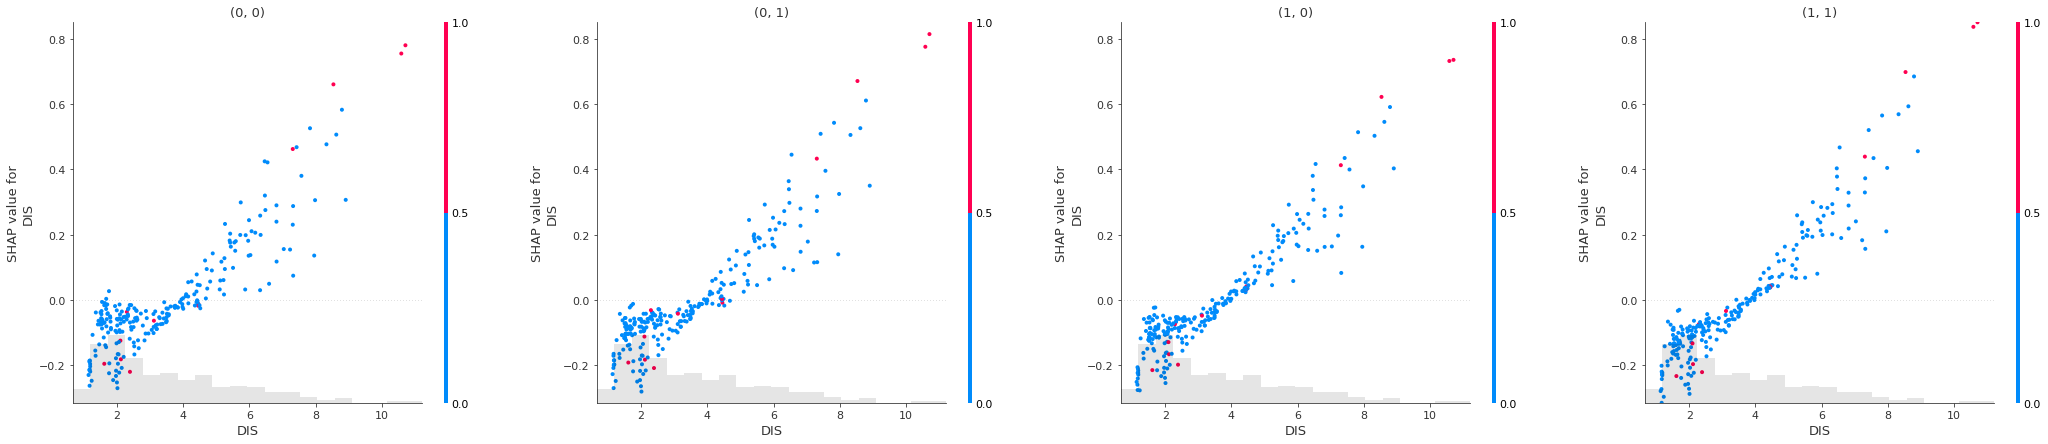

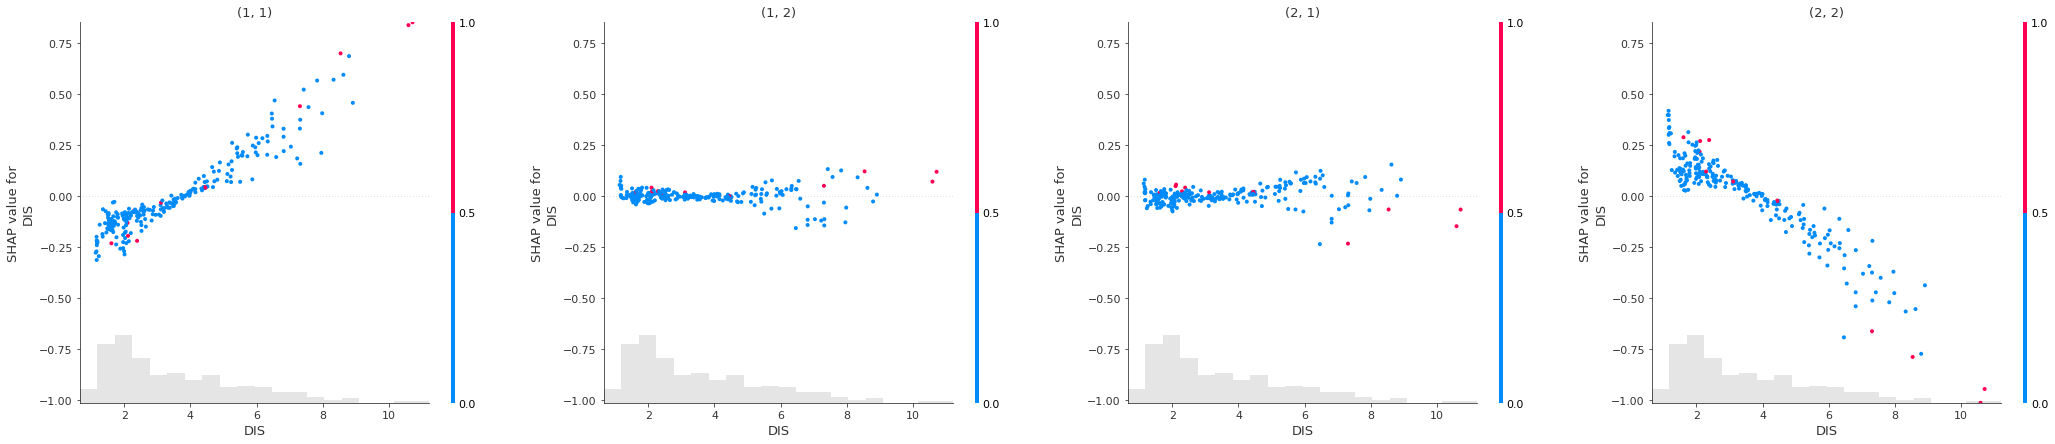

In [40]:
plot_next_feature()

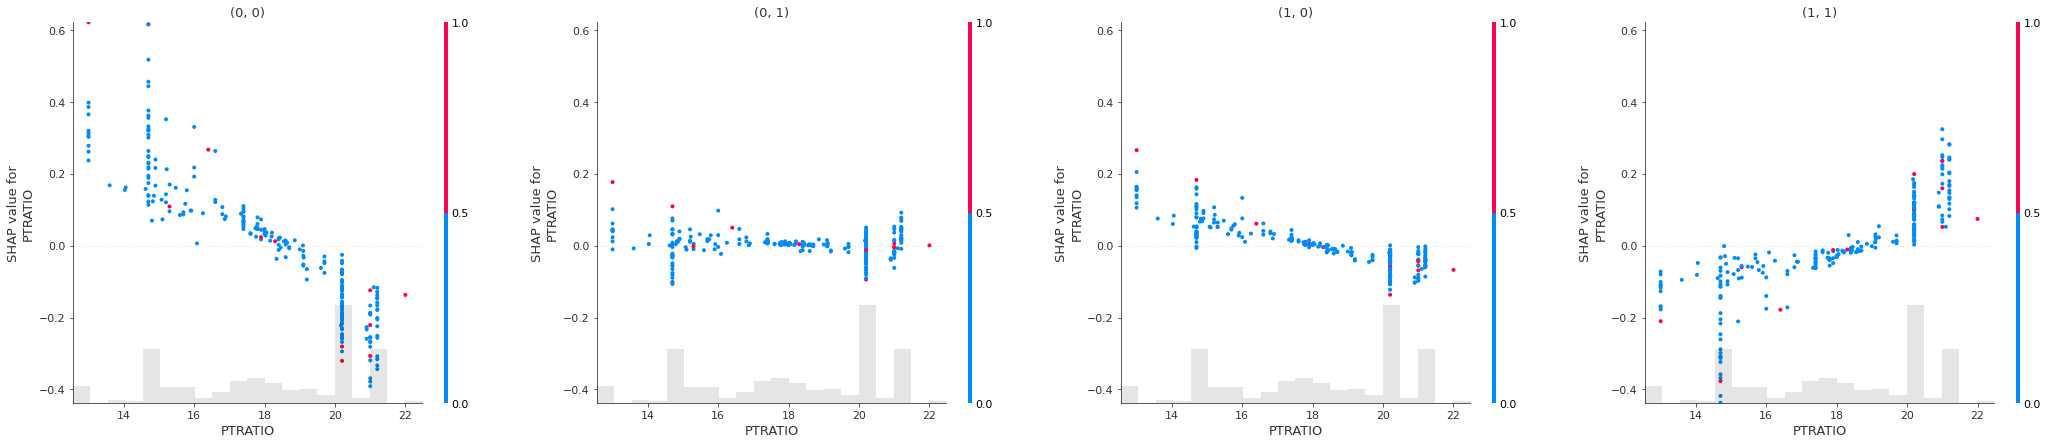

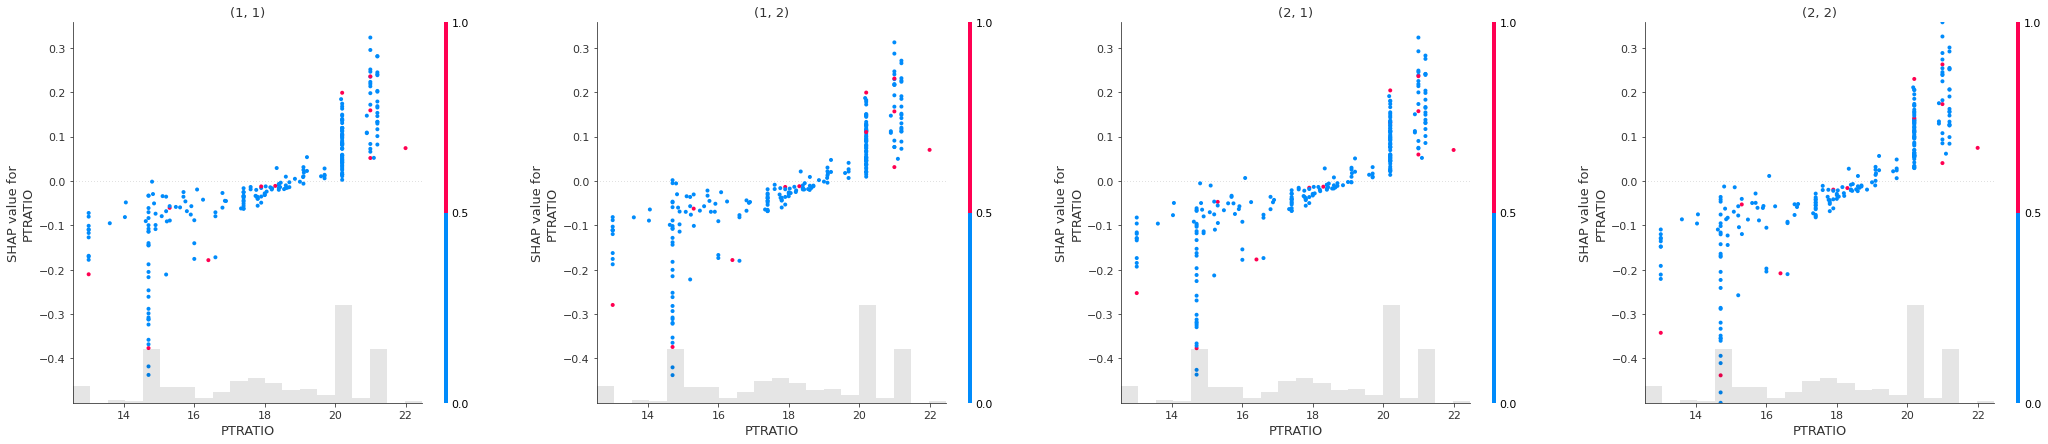

In [41]:
plot_next_feature()

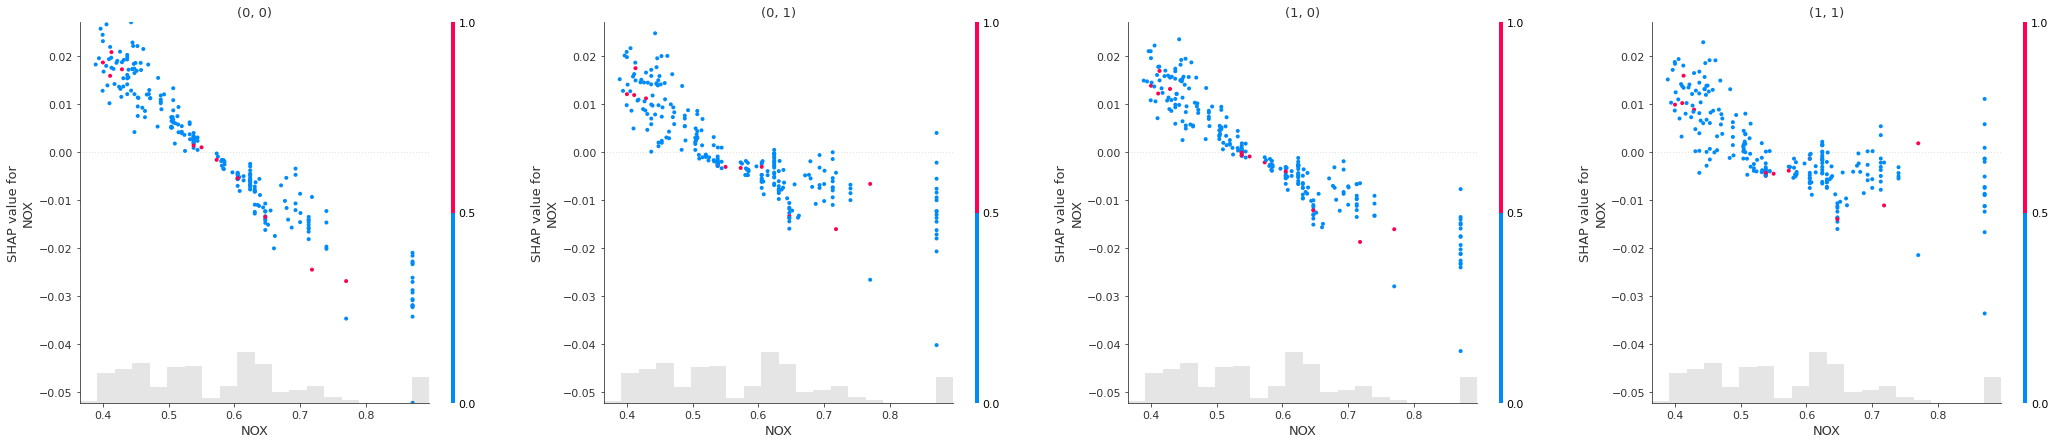

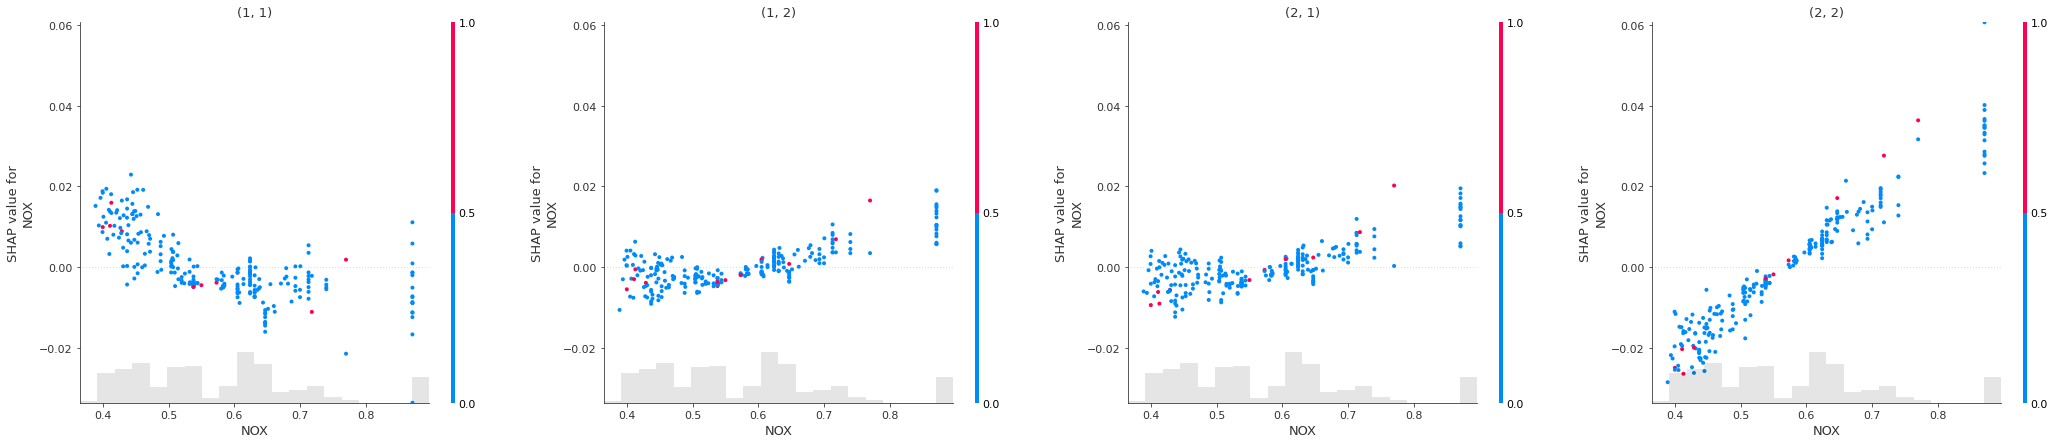

In [42]:
plot_next_feature()

# Local Explanations

In [43]:
pred_classes = comparer.class_names[mclass_diff]

In [85]:
def get_cluster(cluster):
    shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names

In [94]:
def plot_feature(feature):
    plot_feature_effects(shap_values[:, [feature]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}', constrained_layout=True)

## Clustering of Class $(0,1)$ SHAP Values

In [256]:
diff_class = '(0, 1)'
shap_values = explanations.mclass_diff.log_odds[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

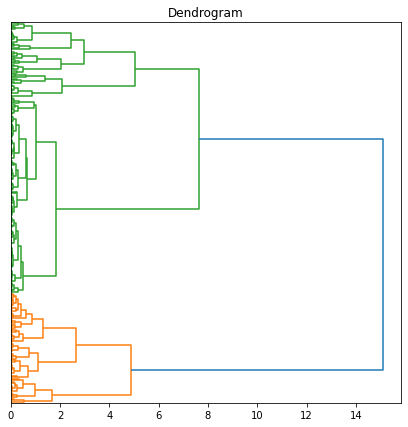

In [257]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [258]:
n_clusters = 3
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c2,86,3,0,2,36,0,0,0,0
c3,0,0,0,0,16,5,0,2,25


In [259]:
cluster, shap_values, pred_classes = get_cluster('c2')
classes = ['(0, 0)', '(0, 1)', '(1, 1)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c2,86,3,0,2,36,0,0,0,0


### Global Effects

Instances in this cluster are characterized by:
- high LSTAT (>8.9)
- low ZN (≤75)
- RM between 3.8 and 7.0

In [260]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,17.682652,1.870079,15.727608,4.032803,5.912323,11.190704,461.788751,1.685039,2.848263,19.088746,0.628806
std,5.291579,8.524059,5.782199,8.345155,0.477941,9.326098,161.653740,0.586905,1.484125,2.274215,0.122820
min,8.997915,0.000000,2.460000,0.013600,3.863000,2.000000,188.000000,0.000000,1.358000,14.700000,0.410000
25%,14.260000,0.000000,9.616443,0.295030,5.630175,4.000000,307.000000,1.500000,1.712689,18.050000,0.538000
50%,16.796984,0.000000,18.100000,1.476257,5.905000,5.000000,430.000000,2.000000,2.328385,20.200000,0.624000
75%,19.730000,0.000000,19.580000,4.982732,6.245500,24.000000,666.000000,2.000000,3.669500,20.900000,0.700266
max,36.980000,75.000000,25.650000,73.534100,6.951000,24.000000,679.526743,2.000000,7.954900,21.200000,0.871000


In [261]:
df['AGE'].value_counts()

2.0    95
1.0    24
0.0     8
Name: AGE, dtype: int64

In [262]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 8.8
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",3.0,NaN
"(1, 1)",NaN,2.0
"(2, 1)",NaN,1.0


In [263]:
n_clusters = 11
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c4,35,1,0,2,12,0,0,0,0
c5,51,2,0,0,24,0,0,0,0
c6,0,0,0,0,0,0,0,1,7
c7,0,0,0,0,2,0,0,1,4
c8,0,0,0,0,4,1,0,0,1
c10,0,0,0,0,1,4,0,0,0


### First Cluster

In [278]:
cluster, shap_values, pred_classes = get_cluster('c4')
classes = ['(0, 0)', '(0, 1)', '(1, 1)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c4,35,1,0,2,12,0,0,0,0


#### Global Effects

Instances in this cluster are characterized by:
- LSTAT between 11.45 and 20.4
- low ZN (≤12.5)
- RM between 5.0 and 6.7
- high AGE (≥1)

In [279]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,16.341627,0.250000,15.660155,3.070169,6.012968,13.279762,493.910535,1.900000,2.801305,19.261399,0.661017
std,1.778408,1.767767,5.344624,2.258621,0.354196,9.800008,166.864957,0.303046,1.139541,2.379943,0.119047
min,11.450000,0.000000,4.050000,0.139140,5.080871,2.000000,188.000000,1.000000,1.488436,14.700000,0.510000
25%,15.552007,0.000000,8.140000,0.883416,5.695397,4.000000,307.000000,2.000000,2.021600,20.177455,0.538000
50%,16.557712,0.000000,18.100000,2.327795,6.023407,5.000000,420.000000,2.000000,2.438485,20.200000,0.665915
75%,17.472796,0.000000,19.210000,5.127412,6.320240,24.000000,666.000000,2.000000,3.607925,21.000000,0.713000
max,20.340000,12.500000,25.650000,7.129026,6.630226,24.000000,679.526743,2.000000,6.592100,21.200000,0.871000


In [280]:
df['AGE'].value_counts()

2.0    45
1.0     5
Name: AGE, dtype: int64

In [281]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 11.45
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",1.0,NaN
"(1, 1)",NaN,1.0


In [282]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 20.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,1.0
"(0, 1)",1.0,NaN


In [283]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['ZN'] = 12.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",1.0,NaN
"(1, 1)",NaN,1.0


#### Local Effects

In [284]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
2,14.19,0.0,18.1,3.83684,6.251,24.0,666.0,2.0,2.2955,20.2,0.77


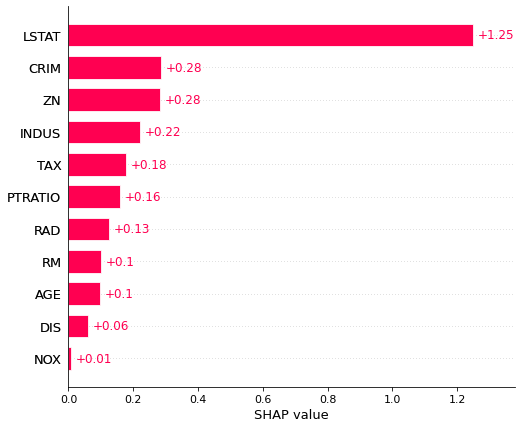

In [285]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

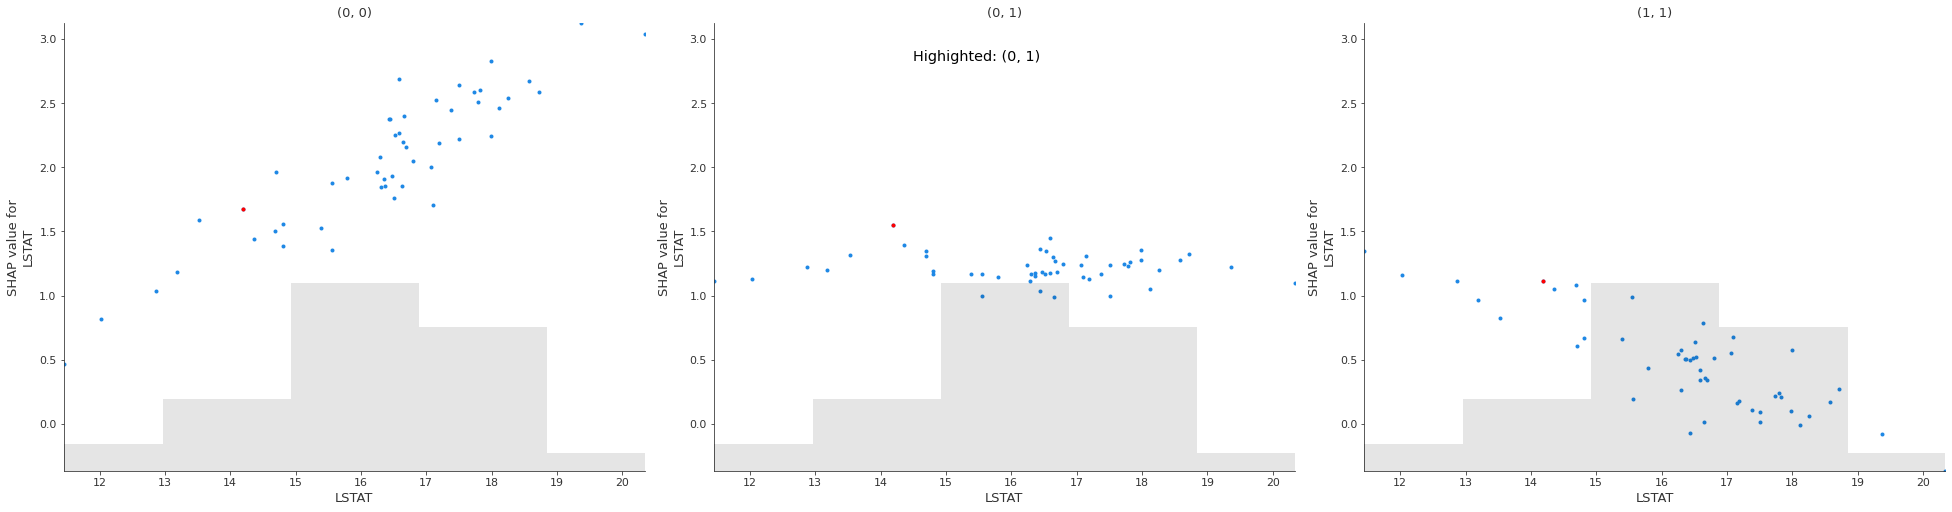

In [286]:
plot_feature('LSTAT')

In [287]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 14.7
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,1.0
"(0, 1)",1.0,NaN


In [288]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 13.9
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",1.0,NaN
"(1, 1)",NaN,1.0


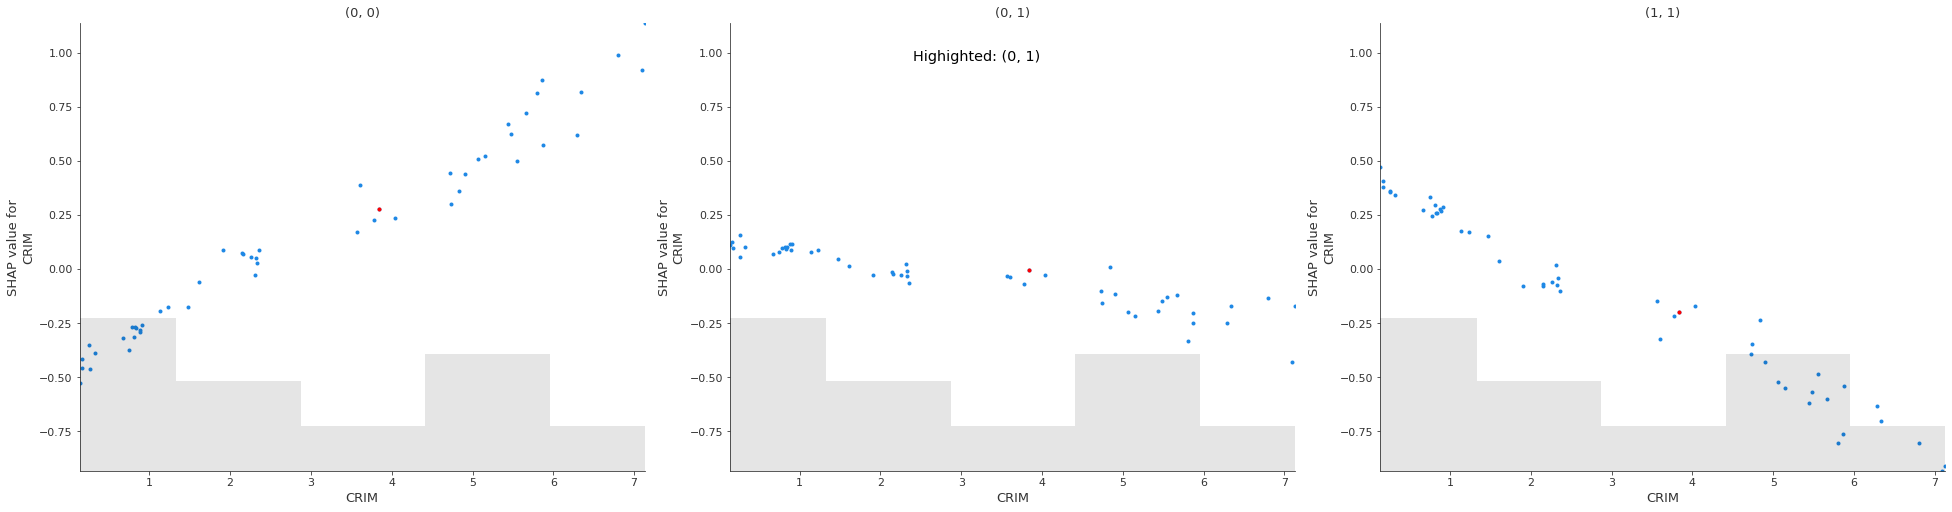

In [289]:
plot_feature('CRIM')

In [111]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['CRIM'] = 3.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",1.0,NaN
"(1, 1)",NaN,1.0


In [116]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['CRIM'] = 4.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,1.0
"(0, 1)",1.0,NaN


### Second Cluster

In [290]:
cluster, shap_values, pred_classes = get_cluster('c5')
classes = ['(0, 0)', '(0, 1)', '(1, 1)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c5,51,2,0,0,24,0,0,0,0


#### Global Effects

Instances in this cluster are characterized by:
- high LSTAT (>8.9)
- low ZN (≤75)
- RM between 3.8 and 7.0

In [291]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,18.553447,2.922078,15.771409,4.657890,5.846969,9.834173,440.930450,1.545455,2.878755,18.976634,0.607890
std,6.513975,10.751703,6.083413,10.543429,0.535567,8.805740,155.731757,0.679502,1.676934,2.211449,0.121431
min,8.997915,0.000000,2.460000,0.013600,3.863000,2.000000,188.000000,0.000000,1.358000,14.700000,0.410000
25%,13.000000,0.000000,9.900000,0.249800,5.559681,4.000000,304.000000,1.000000,1.671736,17.900000,0.520000
50%,18.330000,0.000000,18.100000,0.716682,5.857000,5.000000,430.000000,2.000000,2.100000,20.200000,0.614000
75%,22.740000,0.000000,19.580000,3.967109,6.103000,24.000000,666.000000,2.000000,3.615000,20.200000,0.638056
max,36.980000,75.000000,25.650000,73.534100,6.951000,24.000000,666.000000,2.000000,7.954900,21.200000,0.871000


In [292]:
df['AGE'].value_counts()

2.0    50
1.0    19
0.0     8
Name: AGE, dtype: int64

In [293]:
n_clusters = 20
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c9,35,1,0,2,12,0,0,0,0
c10,51,2,0,0,12,0,0,0,0
c13,0,0,0,0,0,0,0,1,7
c15,0,0,0,0,2,0,0,1,0
c16,0,0,0,0,4,1,0,0,1
c19,0,0,0,0,1,4,0,0,0


In [294]:
cluster, shap_values, pred_classes = get_cluster('c10')
classes = ['(0, 0)', '(0, 1)', '(1, 1)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c10,51,2,0,0,12,0,0,0,0


Instances in this cluster are characterized by:
- high LSTAT (>10.3)
- low ZN (=0)
- high INDUS (>6.9)
- RM between 3.8 and 6.9

In [295]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
count,65.000000,65.0,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,19.854885,0.0,17.600900,5.484629,5.790013,10.618944,466.625302,1.676923,2.438053,19.053859,0.634269
std,6.218183,0.0,4.518419,11.293695,0.534753,9.341889,152.930929,0.589165,1.196073,2.329035,0.113054
min,10.360000,0.0,6.910000,0.045600,3.863000,2.000000,188.000000,0.000000,1.358000,14.700000,0.437000
25%,14.330000,0.0,18.100000,0.277332,5.497879,4.000000,391.000000,1.000000,1.630636,18.340282,0.583000
50%,19.662344,0.0,18.100000,1.249544,5.804262,5.000000,437.000000,2.000000,1.990724,20.200000,0.624000
75%,23.270000,0.0,21.890000,7.050420,6.027000,24.000000,666.000000,2.000000,2.577237,20.900000,0.693000
max,36.980000,0.0,25.650000,73.534100,6.833000,24.000000,666.000000,2.000000,6.320000,21.200000,0.871000


In [296]:
df['AGE'].value_counts()

2.0    48
1.0    13
0.0     4
Name: AGE, dtype: int64

In [297]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 10.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",2.0,NaN
"(1, 1)",NaN,2.0


In [298]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['ZN'] = 2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",2.0,NaN
"(1, 1)",NaN,2.0


#### Local Effects

In [299]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
14,11.10,0.0,19.58,2.3004,6.319,5.0,403.0,2.0,2.1000,14.7,0.605
62,13.51,0.0,13.89,0.0456,5.888,5.0,276.0,1.0,3.1121,16.4,0.550


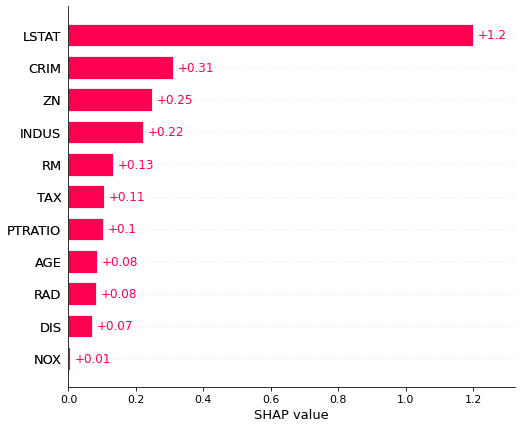

In [300]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

In [301]:
def plot_feature(feature):
    plot_feature_effects(shap_values[:, [feature]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}', constrained_layout=True)

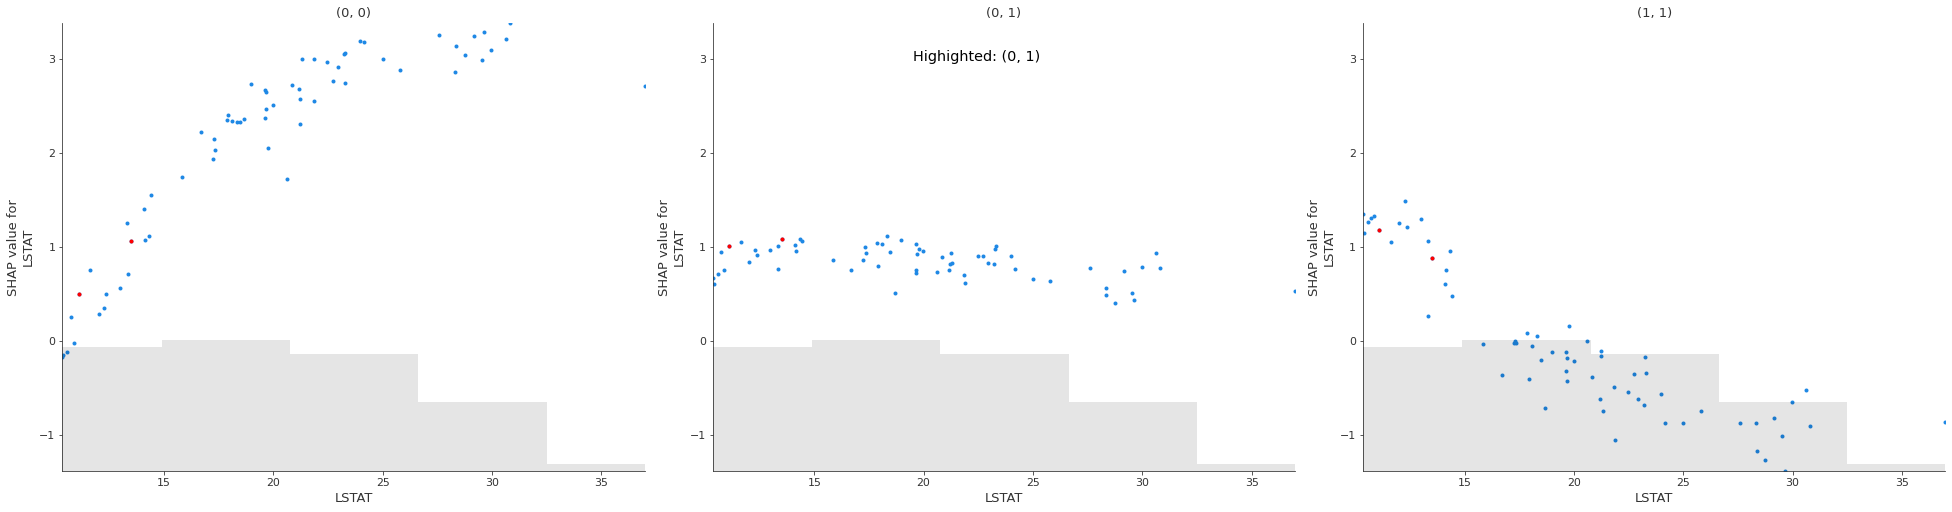

In [302]:
plot_feature('LSTAT')

In [303]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 14.9
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,2.0
"(0, 1)",2.0,NaN


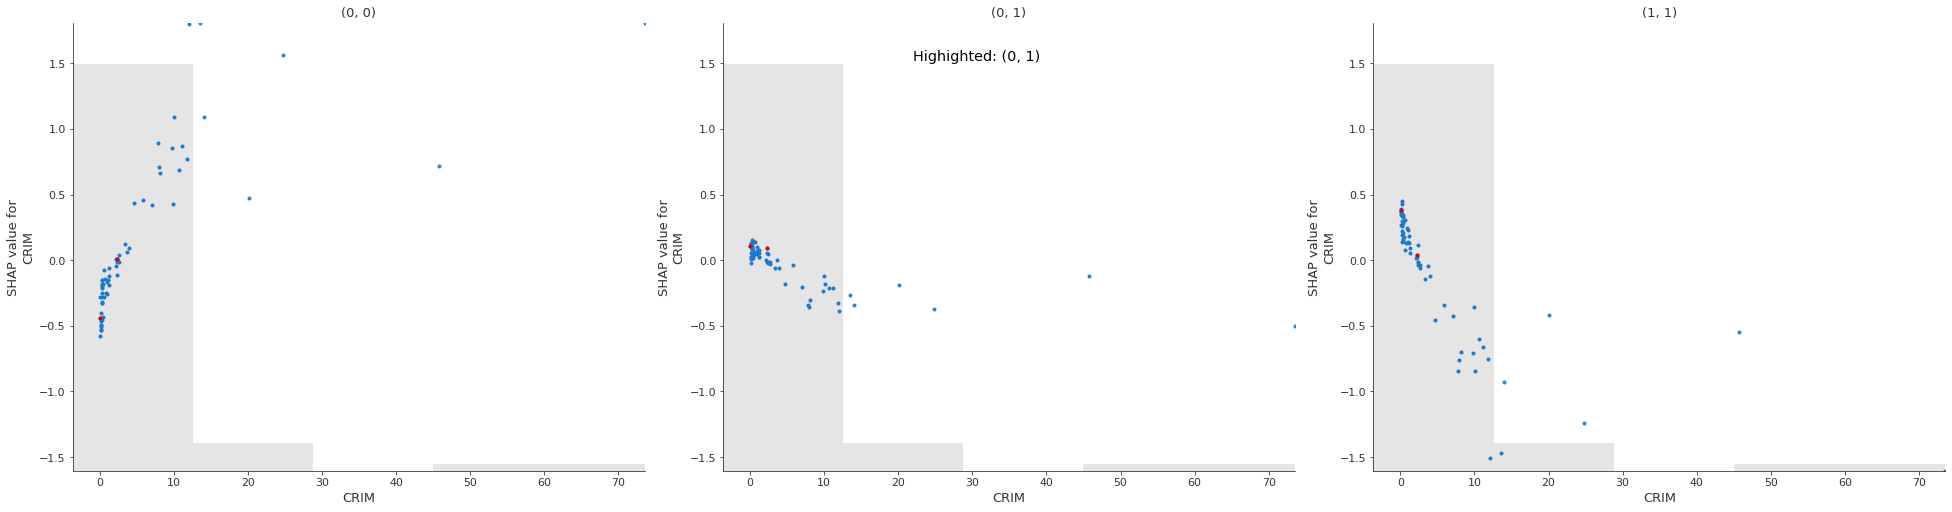

In [304]:
plot_feature('CRIM')

In [149]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['CRIM'] = 2.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,2.0
"(0, 1)",2.0,NaN


## Clustering of Class $(1,0)$ SHAP Values

In [241]:
diff_class = '(1, 0)'
shap_values = explanations.mclass_diff.log_odds[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

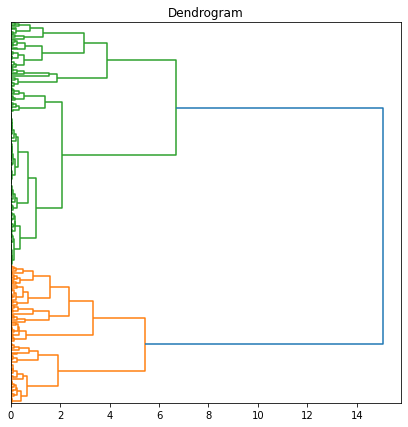

In [242]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [243]:
n_clusters = 3
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c1,0,0,0,0,1,4,0,0,84
c2,86,3,0,2,24,0,0,0,0
c3,0,0,0,0,27,1,0,2,12


In [245]:
cluster, shap_values, pred_classes = get_cluster('c2')
classes = ['(0, 0)', '(1, 0)', '(1, 1)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c2,86,3,0,2,24,0,0,0,0


### Global Effects

Instances in this cluster are characterized by:
- high LSTAT (>10.5)
- low ZN (≤75)
- RM (<6.9)

In [246]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,18.400582,2.065217,16.550898,4.432302,5.880421,11.837729,477.057838,1.773913,2.767046,19.149830,0.641338
std,5.028417,8.938759,5.355008,8.675566,0.473548,9.561076,160.984705,0.496671,1.499336,2.332968,0.121874
min,10.580000,0.000000,4.000000,0.013600,3.863000,2.000000,188.000000,0.000000,1.358000,14.700000,0.410000
25%,15.100000,0.000000,15.304412,0.403155,5.618712,4.000000,320.500000,2.000000,1.682042,18.427230,0.538000
50%,17.310000,0.000000,18.100000,2.242360,5.888000,5.000000,437.000000,2.000000,2.195909,20.200000,0.624000
75%,20.480000,0.000000,19.580000,5.459607,6.229000,24.000000,666.000000,2.000000,3.458054,21.000000,0.713000
max,36.980000,75.000000,25.650000,73.534100,6.833000,24.000000,679.526743,2.000000,7.954900,21.200000,0.871000


In [247]:
df['AGE'].value_counts()

2.0    93
1.0    18
0.0     4
Name: AGE, dtype: int64

In [248]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 10.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 0)",2.0,NaN
"(1, 1)",NaN,2.0


#### Local Effects

In [249]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
10,16.510000,0.0,8.14,0.840540,5.599000,4.0,307.0,2.0,4.454600,21.0,0.538
75,16.476581,0.0,8.14,0.826173,5.650719,4.0,307.0,2.0,4.445848,21.0,0.538


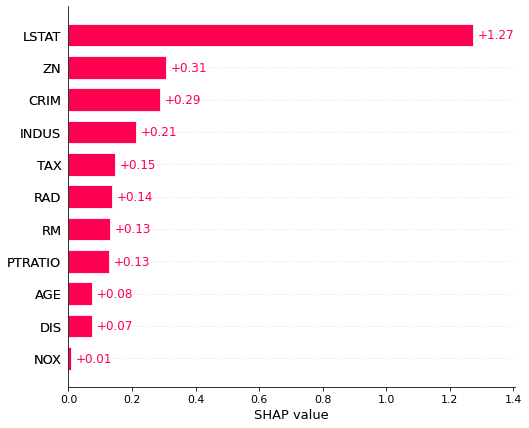

In [250]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

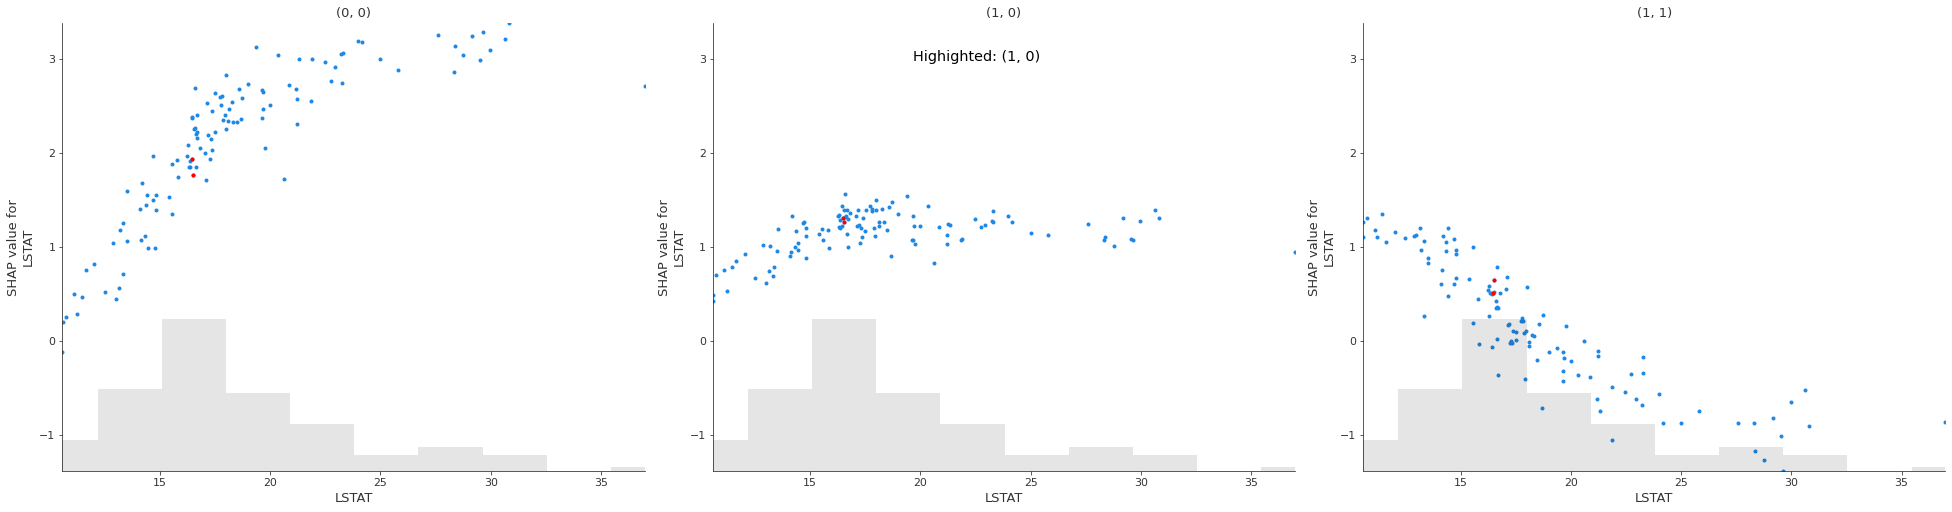

In [251]:
plot_feature('LSTAT')

In [252]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 16.8
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,2.0
"(1, 0)",2.0,NaN


In [253]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 16.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 0)",2.0,NaN
"(1, 1)",NaN,2.0


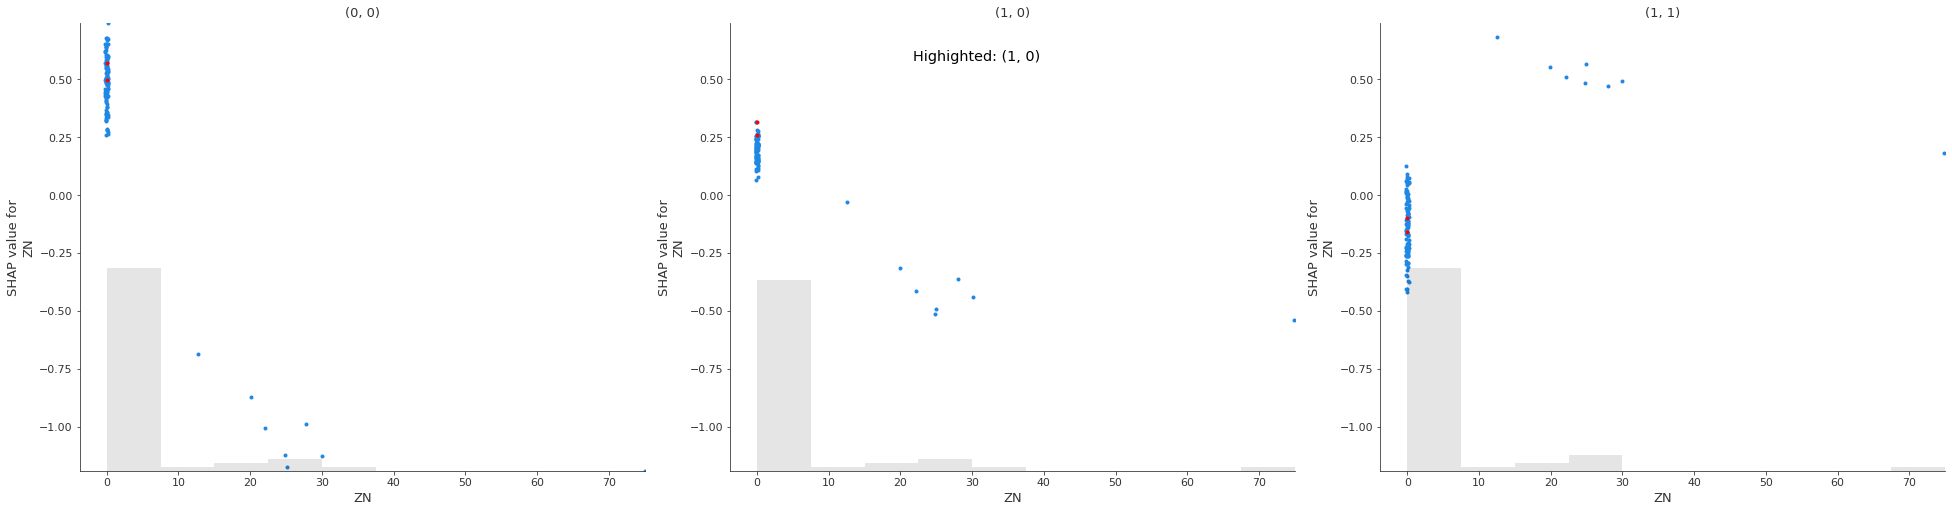

In [254]:
plot_feature('ZN')

In [255]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['ZN'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 0)",2.0,NaN
"(1, 1)",NaN,2.0


## Clustering of Class $(1,2)$ SHAP Values

In [201]:
diff_class = '(1, 2)'
shap_values = explanations.mclass_diff.log_odds[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

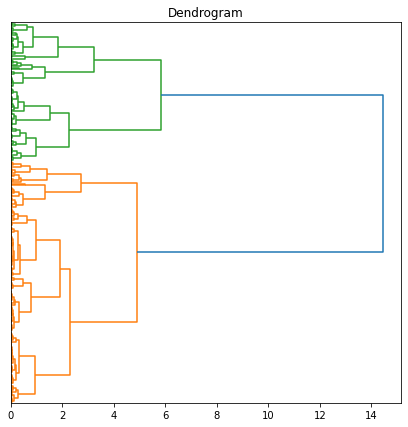

In [202]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [204]:
n_clusters = 4
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c1,0,0,0,0,30,5,0,2,89
c2,3,3,0,0,17,0,0,0,7
c4,35,0,0,2,5,0,0,0,0


In [228]:
cluster, shap_values, pred_classes = get_cluster('c1')
classes = ['(1, 1)', '(1, 2)', '(2, 2)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c1,0,0,0,0,30,5,0,2,89


### Global Effects

Instances in this cluster are characterized by:
- low LSTAT (≤13)
- low INDUS (<19.6)

In [206]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,6.101856,18.758753,8.024706,1.375763,7.034647,7.738883,351.148080,0.944444,3.997493,17.305198,0.519012
std,2.623688,28.635650,6.211105,2.546994,0.818951,7.281712,149.743393,0.803050,2.114414,2.379991,0.092668
min,1.763949,0.000000,1.210000,0.009060,3.561000,1.000000,193.000000,0.000000,1.137912,13.000000,0.389000
25%,3.964336,0.000000,3.165636,0.055858,6.329500,4.000000,251.264059,0.000000,2.245514,15.300000,0.443425
50%,5.374290,0.000000,5.692285,0.229409,7.043412,5.000000,304.000000,1.000000,3.519361,17.400000,0.504256
75%,7.878888,22.746643,12.605000,0.629167,7.687682,8.000000,400.261127,2.000000,5.411464,19.175000,0.605000
max,13.000000,95.000000,19.580000,9.232300,8.638029,24.000000,666.000000,2.000000,10.710300,22.000000,0.871000


In [207]:
df['AGE'].value_counts()

1.0    45
0.0    44
2.0    37
Name: AGE, dtype: int64

In [209]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 13
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,5.0
"(1, 2)",5.0,NaN


In [208]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['INDUS'] = 19.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,5.0
"(1, 2)",5.0,NaN


#### Local Effects

In [210]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
13,5.490000,60.0,1.69,0.079500,6.579000,4.0,411.0,0.0,10.710300,18.3,0.411
28,9.522242,20.0,3.97,0.539742,7.225003,5.0,264.0,1.0,2.115348,13.0,0.647
36,7.850000,90.0,2.97,0.009060,7.088000,1.0,285.0,0.0,7.307300,15.3,0.400
65,6.360000,85.0,4.15,0.018700,6.516000,4.0,351.0,0.0,8.535300,17.9,0.429
107,5.570000,80.0,1.91,0.106590,5.936000,4.0,334.0,0.0,10.585700,22.0,0.413


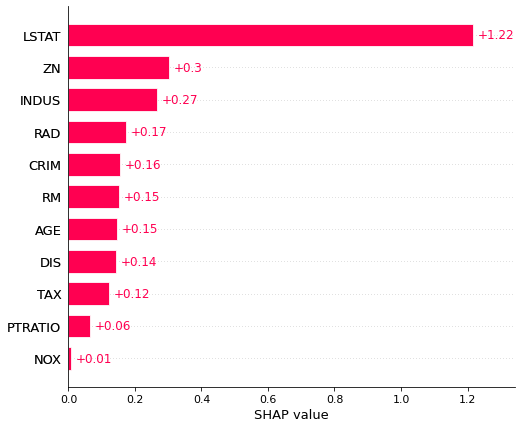

In [230]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

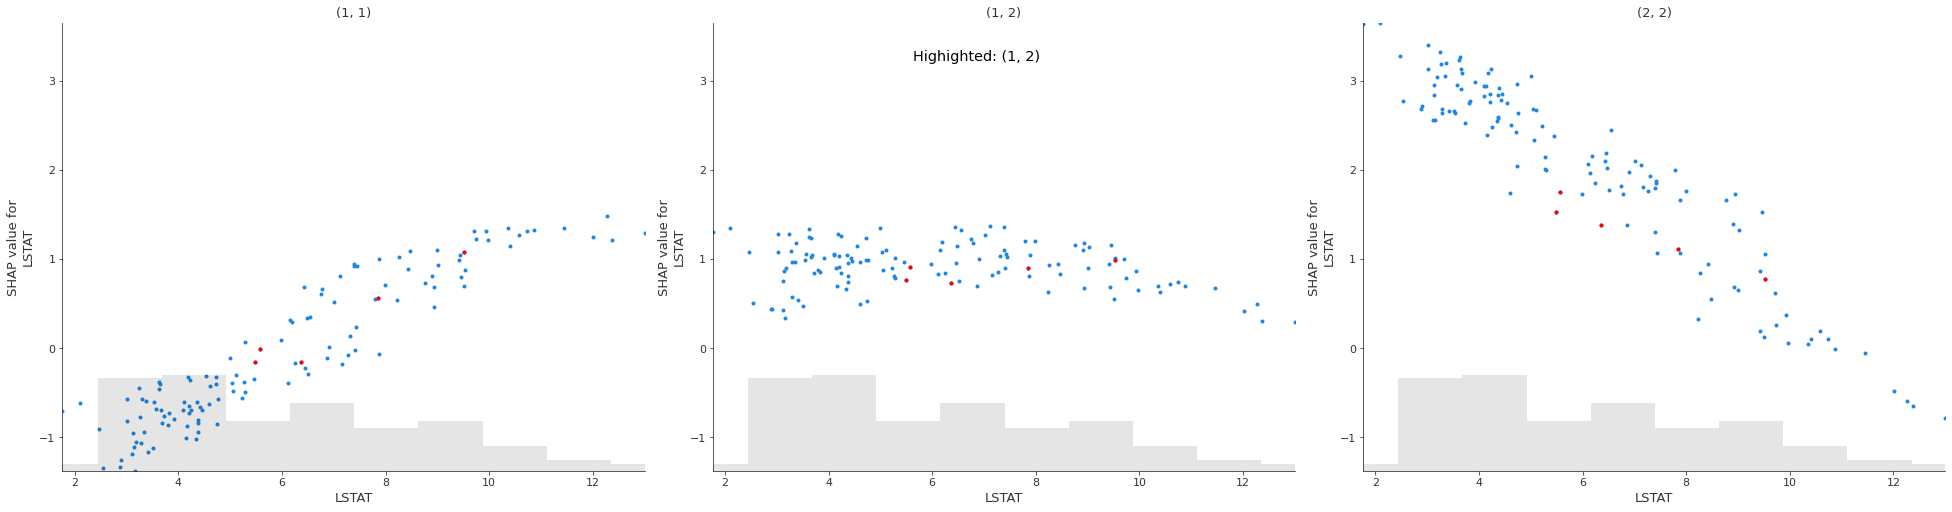

In [231]:
plot_feature('LSTAT')

In [219]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 11.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,5.0
"(1, 2)",5.0,NaN


In [226]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 3.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 2)",5.0,NaN
"(2, 2)",NaN,5.0


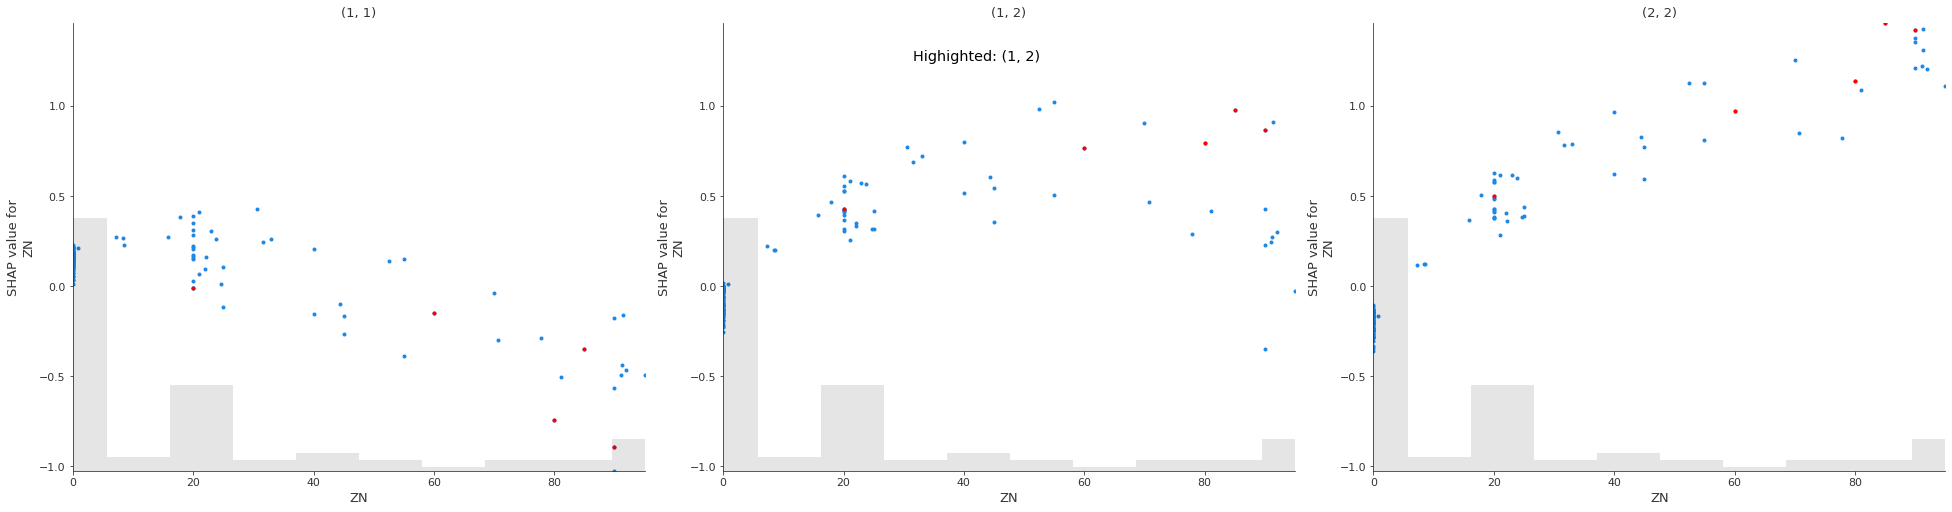

In [232]:
plot_feature('ZN')

In [240]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['ZN'] = 16
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,5.0
"(1, 2)",5.0,NaN


## Clustering of Class $(2,1)$ SHAP Values

In [305]:
diff_class = '(2, 1)'
shap_values = explanations.mclass_diff.log_odds[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

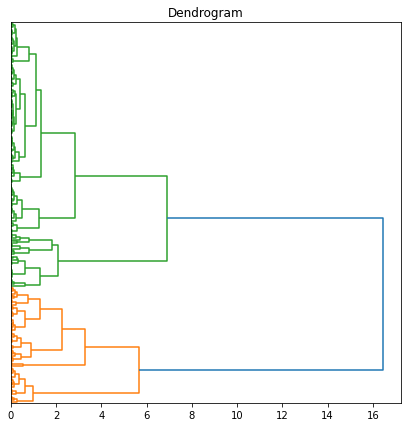

In [306]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [311]:
n_clusters = 3
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c2,11,3,0,2,19,0,0,0,0
c3,0,0,0,0,33,5,0,2,96


In [314]:
cluster, shap_values, pred_classes = get_cluster('c3')
classes = ['(1, 1)', '(2, 1)', '(2, 2)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c3,0,0,0,0,33,5,0,2,96


### Global Effects

Instances in this cluster are characterized by:
- low LSTAT (≤13)
- low INDUS (<19.6)

In [315]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,6.072134,21.907364,7.747029,1.278580,7.033963,7.500003,344.683597,0.897059,4.150206,17.294571,0.512434
std,2.677259,30.713248,6.147189,2.475202,0.798327,7.076642,146.362993,0.800735,2.150551,2.343488,0.092399
min,1.763949,0.000000,1.210000,0.009060,3.561000,1.000000,193.000000,0.000000,1.137912,13.000000,0.389000
25%,3.783966,0.000000,3.050829,0.054925,6.376000,4.000000,245.613237,0.000000,2.421900,15.280081,0.437000
50%,5.287440,0.000000,5.255000,0.147890,7.043412,5.000000,294.260013,1.000000,3.681574,17.400000,0.491000
75%,7.907147,30.145027,11.930000,0.624351,7.659645,7.250000,398.000000,2.000000,5.548544,19.092823,0.590000
max,13.000000,100.000000,19.580000,9.232300,8.638029,24.000000,666.000000,2.000000,10.710300,22.000000,0.871000


In [316]:
df['AGE'].value_counts()

0.0    51
1.0    48
2.0    37
Name: AGE, dtype: int64

In [330]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 13
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,1.0
"(1, 1)",NaN,1.0
"(2, 1)",2.0,NaN


The hypothesis, that the effect shifts towards $(1,1)$ does not hold for all instances. I will split the cluster.

In [324]:
n_clusters = 6
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust') - 1
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c4,11,3,0,2,19,0,0,0,0
c5,0,0,0,0,5,0,0,2,25
c6,0,0,0,0,28,5,0,0,71


In [325]:
cluster, shap_values, pred_classes = get_cluster('c5')
classes = ['(1, 1)', '(2, 1)', '(2, 2)']

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c5,0,0,0,0,5,0,0,2,25


Instances in this cluster are characterized by:
- low LSTAT (≤9.6)
- low ZN (=0)
- low INDUS (<19.6)

In [326]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.iloc[:, global_feature_order].describe()

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
count,32.000000,32.0,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,6.054026,0.0,16.266250,4.342750,6.616964,14.993671,519.996278,1.687500,2.171168,18.588135,0.612125
std,2.325373,0.0,4.742214,3.433928,0.827489,9.803357,164.222502,0.644455,1.341700,2.359454,0.084439
min,1.763949,0.0,2.890000,0.037380,3.561000,1.000000,224.000000,0.000000,1.137912,14.700000,0.437000
25%,4.049586,0.0,18.100000,1.336806,6.234373,5.000000,403.000000,2.000000,1.186395,16.855081,0.597000
50%,6.455000,0.0,18.100000,4.548895,6.454000,24.000000,666.000000,2.000000,1.761600,20.200000,0.631000
75%,7.839647,0.0,18.434996,7.304708,7.135250,24.000000,666.000000,2.000000,2.421225,20.200000,0.637877
max,9.530000,0.0,19.580000,9.232300,7.905616,24.000000,666.000000,2.000000,6.458400,21.000000,0.871000


In [327]:
df['AGE'].value_counts()

2.0    25
1.0     4
0.0     3
Name: AGE, dtype: int64

In [331]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 9.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,2.0
"(2, 1)",2.0,NaN


In [342]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['ZN'] = 19
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(2, 1)",2.0,NaN
"(2, 2)",NaN,2.0


In [360]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['INDUS'] = 19.7
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,2.0
"(2, 1)",2.0,NaN


### Local Effects

In [344]:
df.iloc[pred_classes == diff_class, global_feature_order]

,LSTAT,ZN,INDUS,CRIM,RM,RAD,TAX,AGE,DIS,PTRATIO,NOX
5,7.12,0.0,18.10,4.55587,3.561,24.0,666.0,2.0,1.6132,20.2,0.718
13,6.48,0.0,11.93,0.10959,6.794,1.0,273.0,2.0,2.3889,21.0,0.573


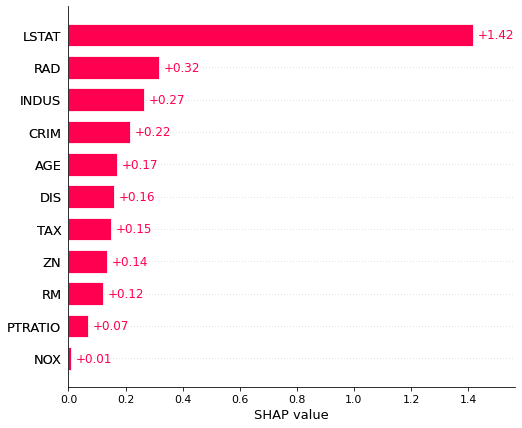

In [345]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(feature_importances)

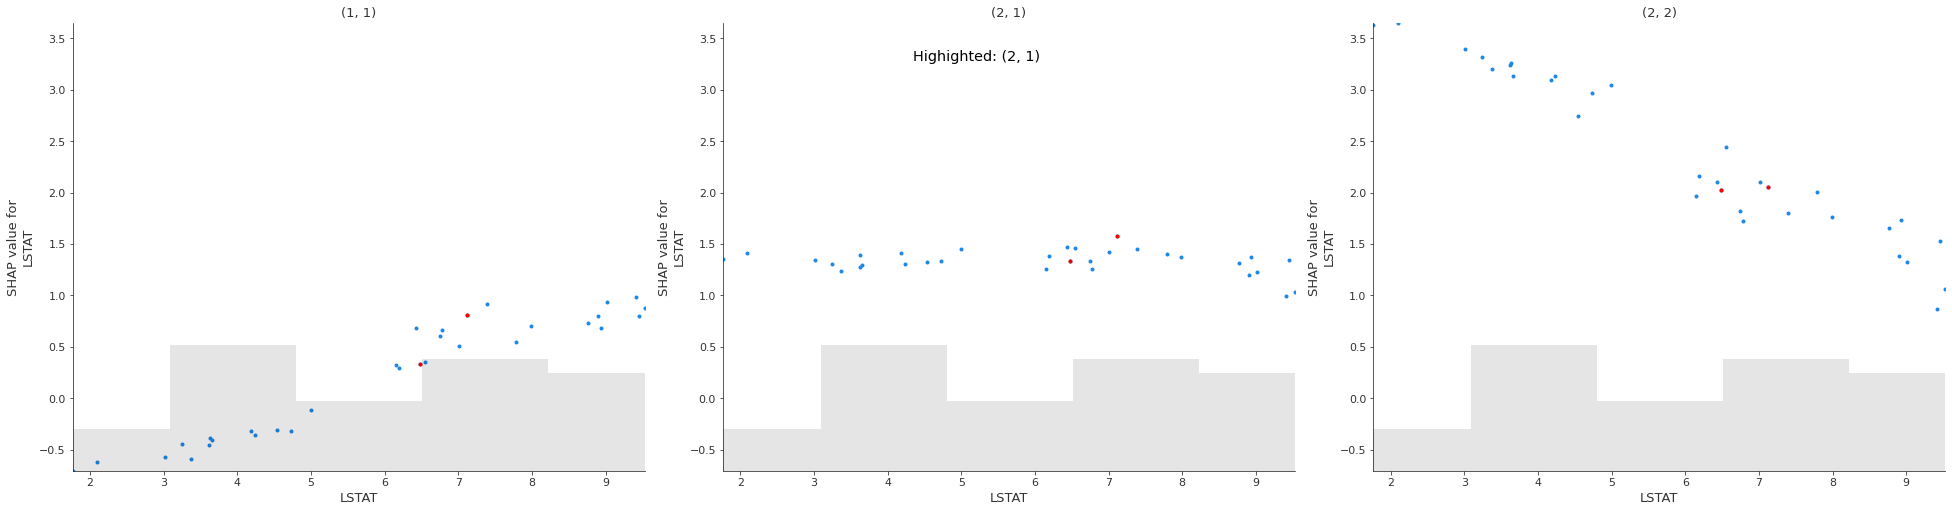

In [346]:
plot_feature('LSTAT')

In [350]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 7.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 1)",NaN,2.0
"(2, 1)",2.0,NaN


In [353]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['LSTAT'] = 6.0
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(2, 1)",2.0,NaN
"(2, 2)",NaN,2.0


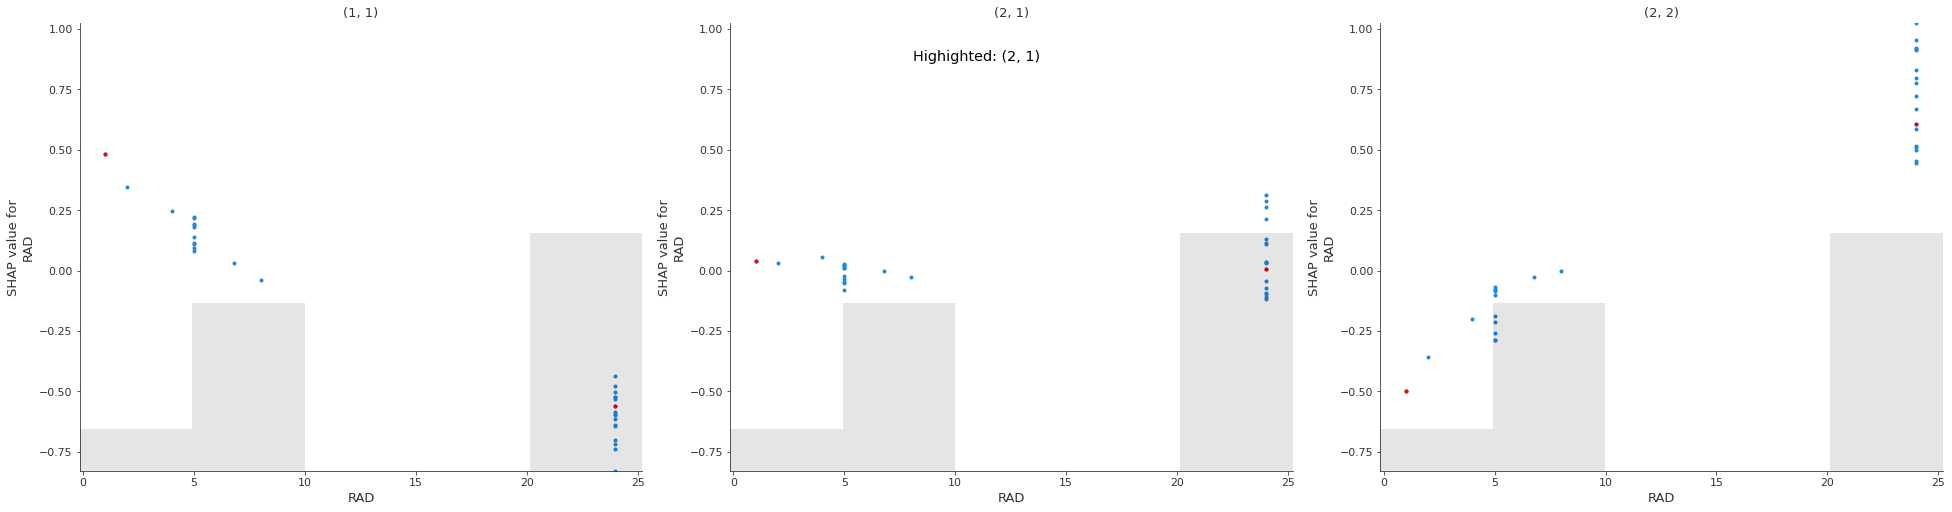

In [354]:
plot_feature('RAD')

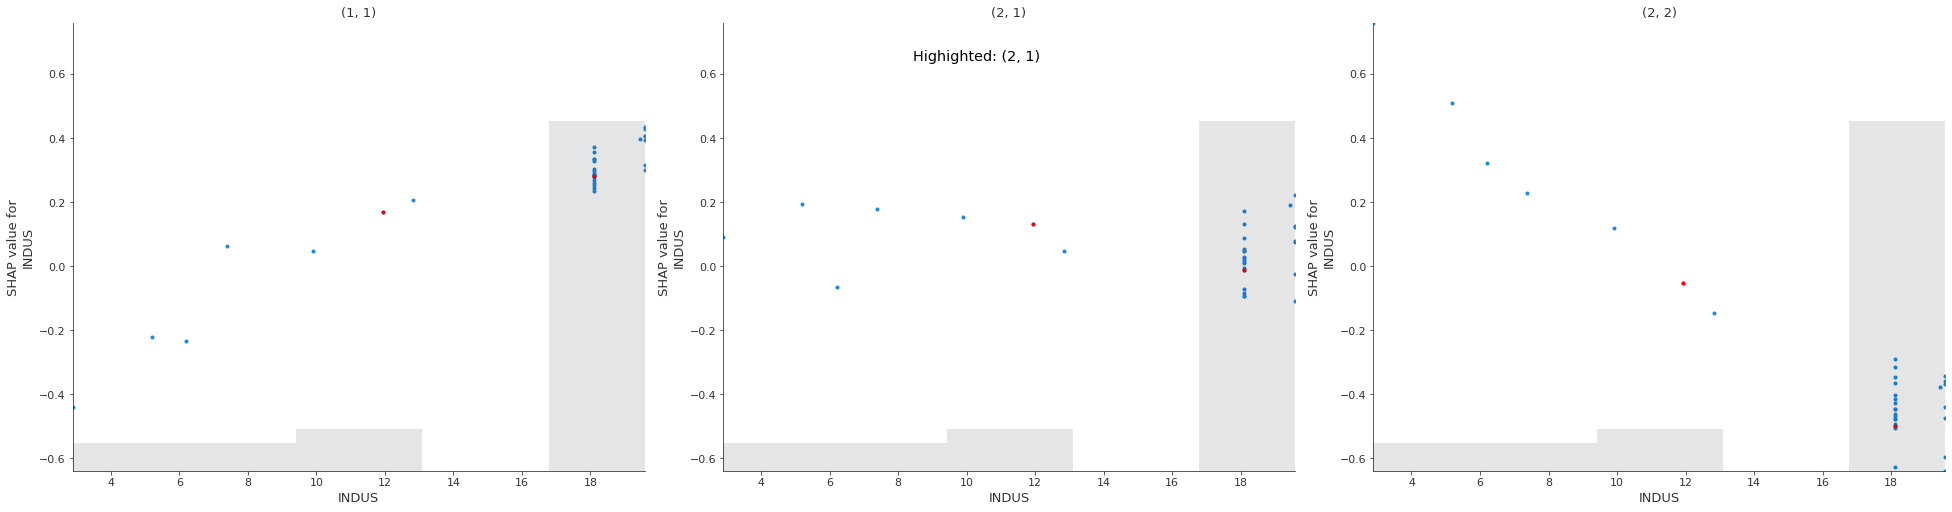

In [355]:
plot_feature('INDUS')

In [357]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['INDUS'] = 9
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(2, 1)",2.0,NaN
"(2, 2)",NaN,2.0
